In [ ]:
import random

from functools import partial
from IPython.display import display, HTML

from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import optuna
from pandarallel import pandarallel
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

pd.options.display.float_format = '{:.2f}'.format
pandarallel.initialize(progress_bar=True)
random.seed(42)
np.random.seed(42)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('modified_train.csv', index_col=0)

In [3]:
df['created_date'] = pd.to_datetime(df['created_date'], format='ISO8601')

In [4]:
df = df[df['created_date'] >= '2016-04-01']

In [5]:
# Сортировка данных для дальнейшего разделения по временной метке
df = df.sort_values('created_date').reset_index(drop=True)

In [6]:
df[df.toxicity_b == 0].shape

(1585541, 38)

In [7]:
df[df.toxicity_b == 1].shape

(199767, 38)

In [8]:
print('Процентное соотношение значений ' + str(df['toxicity_b'].value_counts(normalize=True) * 100))

Процентное соотношение значений toxicity_b
0   88.81
1   11.19
Name: proportion, dtype: float64


In [9]:
df['ctws'].fillna('', inplace=True)

/var/folders/hr/sq9687tj13d9h3kr4gw5mrz80000gn/T/ipykernel_18866/3616255057.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ctws'].fillna('', inplace=True)


# Baseline

In [10]:
X = df['ctws']
y = df['toxicity_b']

In [11]:
def show_baseline_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy:.2f}\t\tPrecision: {precision:.2f}\t\tRecall: {recall:.2f}\t\tF1: {f1:.2f}')

    cm = confusion_matrix(y_true, y_pred, normalize='all')
    labels = ['Non-Toxic (0)', 'Toxic (1)']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted')
    plt.title(f'Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

## Случайное предсказание

Accuracy: 0.50		Precision: 0.11		Recall: 0.50		F1: 0.18


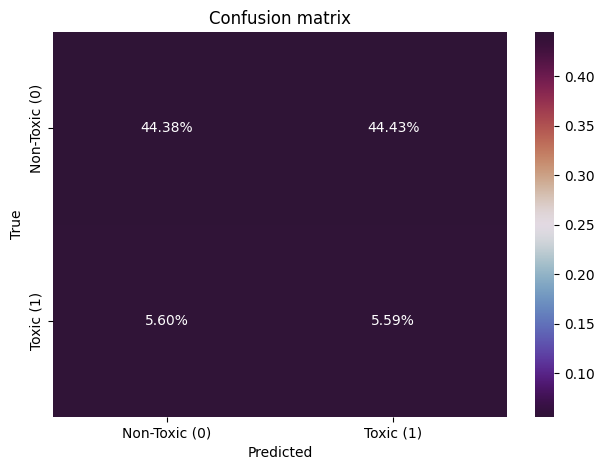

In [12]:
def random_prediction(texts):
    return [random.choice([0, 1]) for _ in texts]

show_baseline_metrics(y, random_prediction(X))

Случайное предсказание просто поделило метки пополам

## Предсказание самого частого класса

/Users/lev_k/HSE/YP/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.89		Precision: 0.00		Recall: 0.00		F1: 0.00


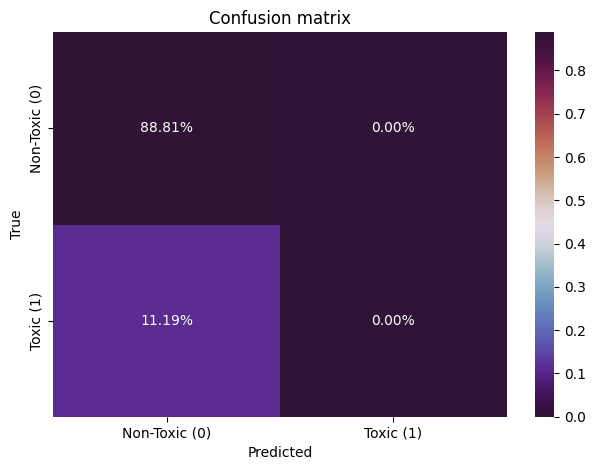

In [13]:
from collections import Counter

def most_frequent_class_prediction(labels, texts):
    most_common_class = Counter(labels).most_common(1)[0][0]
    return [most_common_class] * len(texts)

show_baseline_metrics(y, most_frequent_class_prediction(y, X))

Взглянув на метрику `Accuracy` можно подумать, что модель справляется хорошо, но это не так, потому что классы в датасете несбалансированы, и нетоксичных комментариев сильно больше.

Поэтому данный метод присваивает всем текстам отрицательный класс (это также видно по матрице ошибок), из-за чего метрики точности, полноты и F1 зануляются.

## Lexicon-based подход

Также можно попробовать lexicon-based подход с определением тональности текстов

In [14]:
df_lb = df.copy()

In [15]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lev_k/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
sia = SentimentIntensityAnalyzer()

def extract_vader_features(text):
    scores = sia.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

vader_features = df_lb['ctws'].parallel_apply(extract_vader_features)
vader_features.columns = ['neg', 'neu', 'pos', 'compound']

df_lb = pd.concat([df_lb, vader_features], axis=1)

Accuracy: 0.70		Precision: 0.20		Recall: 0.57		F1: 0.30


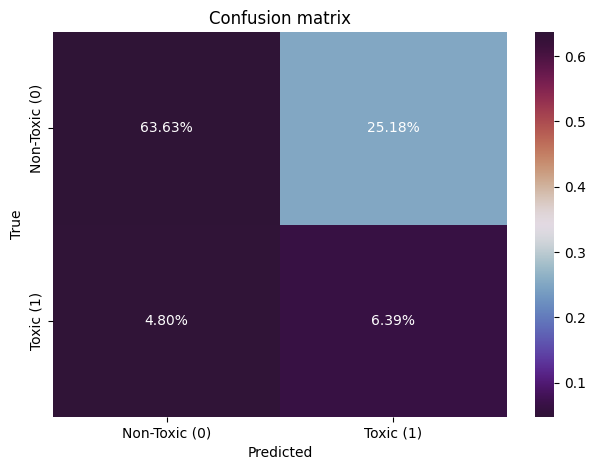

In [17]:
def classify_sentiment(score):
    if score <= -0.2:
        return 1
    return 0

show_baseline_metrics(y, df_lb['compound'].apply(classify_sentiment))

Классификация на основе тональности текста показывает себя уже лучше, но помечает много нетоксичных комментариев как токсичные (был взят порог, который ипользовался для составления столбца "toxicity" (0.4) и переведен в шкалу от -1 до 1 (-0.2))

# Обучение моделей

## Одноклассовая класификация

In [10]:
split_date = df.iloc[int(len(df) * 0.8)]['created_date']
split_date

Timestamp('2017-09-03 13:54:26.194849+0000', tz='UTC')

In [11]:
train_val_df = df[df['created_date'] <= split_date]
test_df = df[df['created_date'] > split_date]

In [12]:
X_test = test_df['ctws']
y_test = test_df['toxicity_b']

In [13]:
split_date = train_val_df.iloc[int(len(train_val_df) * 0.8)]['created_date']
split_date

Timestamp('2017-07-06 03:02:41.334553+0000', tz='UTC')

In [14]:
train_df = train_val_df[train_val_df['created_date'] <= split_date]
val_df = train_val_df[train_val_df['created_date'] > split_date]

In [15]:
X_train = train_df['ctws']
y_train = train_df['toxicity_b']

X_val = val_df['ctws']
y_val= val_df['toxicity_b']

In [16]:
y_train.mean(), y_test.mean(), y_val.mean()

(0.10893507602848947, 0.11765776716023313, 0.11653112736260235)

In [28]:
# Функция обучения модели и предсказания и визуализации результатов
def train_and_predict_toxicity(model, X_train, X_val, X_test, y_train):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        # Вероятности для положительного класса
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_val = model.predict_proba(X_val)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_val = model.decision_function(X_val)
        y_pred_proba_test = model.decision_function(X_test)
    else:
        y_pred_proba_train = None
        y_pred_proba_val = None
        y_pred_proba_test = None

    return y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test

# Функция для отображения метрик
def show_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test, title):
    precision_train = precision_score(y_train, y_pred_train)
    precision_val = precision_score(y_val, y_pred_val)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_val = recall_score(y_val, y_pred_val)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_val = f1_score(y_val, y_pred_val)
    f1_test = f1_score(y_test, y_pred_test)

    print(title + '\n')

    print('Precision\t\tRecall\t\t\tF1\n')
    print(f'Train: {precision_train:.2f}\t\tTrain: {recall_train:.2f}\t\tTrain: {f1_train:.2f}')
    print(f'Val: {precision_val:.2f}\t\tVal: {recall_val:.2f}\t\tVal: {f1_val:.2f}')
    print(f'Test: {precision_test:.2f}\t\tTest: {recall_test:.2f}\t\tTest: {f1_test:.2f}')

    def show_confusion_matrix(y_true, y_pred, sample_name, ax):
        cm = confusion_matrix(y_true, y_pred, normalize='all')
        labels = ['Non-Toxic (0)', 'Toxic (1)']
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        
        sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted', ax=ax)
        ax.set_title(f'Confusion matrix ({sample_name})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc = roc_auc_score(y_true, y_pred_proba)

        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
        ax.grid(True)
    
    def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        auc_pr = auc(recall, precision)

        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
        ax.grid(True)

    if y_pred_proba_train is not None and y_pred_proba_test is not None:
        _, axs = plt.subplots(3, 3, figsize=(18, 16))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0, 0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[0, 1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[0, 2])

        show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
        show_roc_curve(y_val, y_pred_proba_val, title, 'Val', axs[1, 1])
        show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 2])

        show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
        show_pr_curve(y_val, y_pred_proba_val, title, 'Val', axs[2, 1])
        show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 2])
    else:
        _, axs = plt.subplots(1, 3, figsize=(14, 6))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[2])

    plt.tight_layout()
    plt.show()

In [29]:
# Функция получеия мешка слов
def get_bows(X_train, X_val, X_test, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_val), vectorizer.transform(X_test)


# Векторизация  TF-IDF
def get_tfidf(X_train, X_val, X_test, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_val), vectorizer.transform(X_test)

In [30]:
def svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    svc = LinearSVC(C=C, dual=False)
    svc.fit(X_train, y_train)
    
    y_pred = svc.predict(X_val)
    return f1_score(y_val, y_pred)

def mnb_objective(trial, X_train, X_val, y_train, y_val):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train, y_train)
    
    y_pred = mnb.predict(X_val)
    return f1_score(y_val, y_pred)

def cb_objective(trial, X_train, X_val, y_train, y_val):
    params = {
        'loss_function': 'Logloss',
        'verbose': False,
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 50
    }
    
    cb = CatBoostClassifier(**params)
    cb.fit(X_train, y_train)
    
    y_pred = cb.predict(X_val)
    return f1_score(y_val, y_pred)

In [31]:
def get_hyperparams(X_train, X_val, y_train, y_val, objective_func, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(
        objective_func,
        X_train=X_train, X_val=X_val,
        y_train=y_train, y_val=y_val
    ), n_trials=n_trials)
    
    return study.best_params

### Обучение с мешком слов

In [21]:
X_train_bow, X_val_bow, X_test_bow = get_bows(X_train, X_val, X_test)

#### Логистическая регрессия

In [33]:
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_val,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

LogisticRegression BoW

Precision		Recall			F1

Train: 0.81		Train: 0.53		Train: 0.64
Val: 0.74		Val: 0.48		Val: 0.58
Test: 0.74		Test: 0.48		Test: 0.58


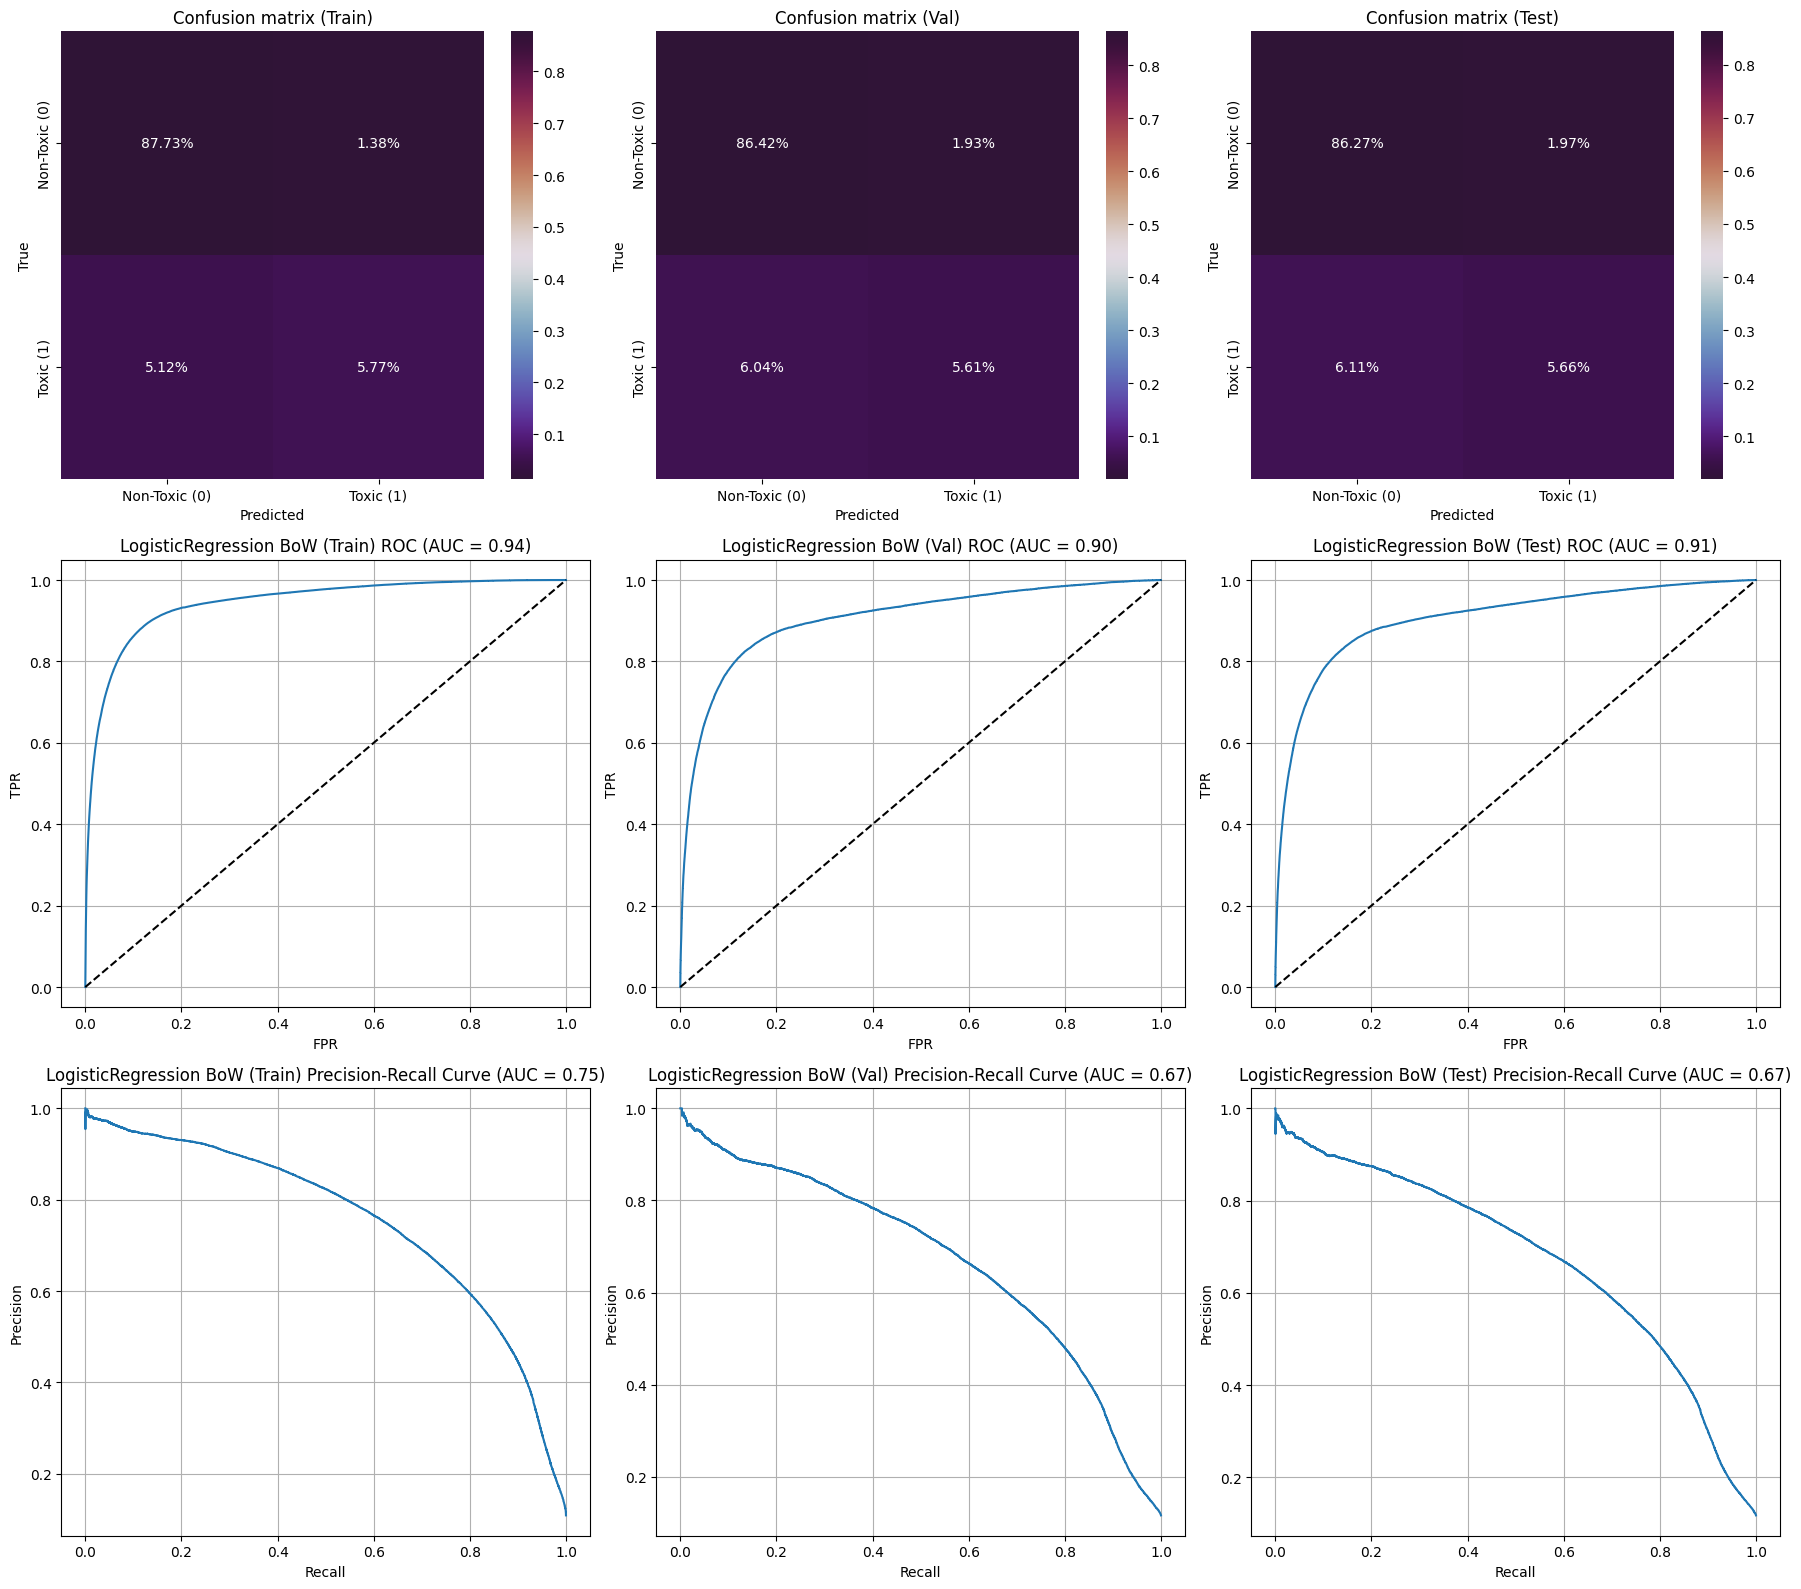

In [42]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_val=y_log_reg_bow_pred_val,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

#### SVM

In [ ]:
best_C = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, svc_objective, n_trials=20).get('C', 1)
(
    y_linear_svc_bow_pred_train,
    y_linear_svc_bow_pred_val,
    y_linear_svc_bow_pred_test,
    y_linear_svc_bow_pred_proba_train,
    y_linear_svc_bow_pred_proba_val,
    y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(C=best_C, dual=False),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_val=y_linear_svc_bow_pred_val,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

#### Наивный Байес

##### Слова

In [46]:
best_alpha = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_bow_pred_train,
    y_nb_bow_pred_val,
    y_nb_bow_pred_test,
    y_nb_bow_pred_proba_train,
    y_nb_bow_pred_proba_val,
    y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2024-12-03 23:00:57,584] A new study created in memory with name: no-name-3eb36d87-adf0-4baf-99fc-5315132e4f1f
[I 2024-12-03 23:00:58,079] Trial 0 finished with value: 0.5223840867292614 and parameters: {'alpha': 0.024624969857499356}. Best is trial 0 with value: 0.5223840867292614.
[I 2024-12-03 23:00:58,249] Trial 1 finished with value: 0.5289587891829161 and parameters: {'alpha': 0.18977806889049995}. Best is trial 1 with value: 0.5289587891829161.
[I 2024-12-03 23:00:58,422] Trial 2 finished with value: 0.5307563966728777 and parameters: {'alpha': 0.274250808638785}. Best is trial 2 with value: 0.5307563966728777.
[I 2024-12-03 23:00:58,573] Trial 3 finished with value: 0.530196859478037 and parameters: {'alpha': 0.24643314516995599}. Best is trial 2 with value: 0.5307563966728777.
[I 2024-12-03 23:00:58,722] Trial 4 finished with value: 0.5216664243129272 and parameters: {'alpha': 0.018849127379802422}. Best is trial 2 with value: 0.5307563966728777.
[I 2024-12-03 23:00:58,872]

MultinomialNB BoW

Precision		Recall			F1

Train: 0.50		Train: 0.63		Train: 0.56
Val: 0.48		Val: 0.61		Val: 0.54
Test: 0.50		Test: 0.59		Test: 0.54


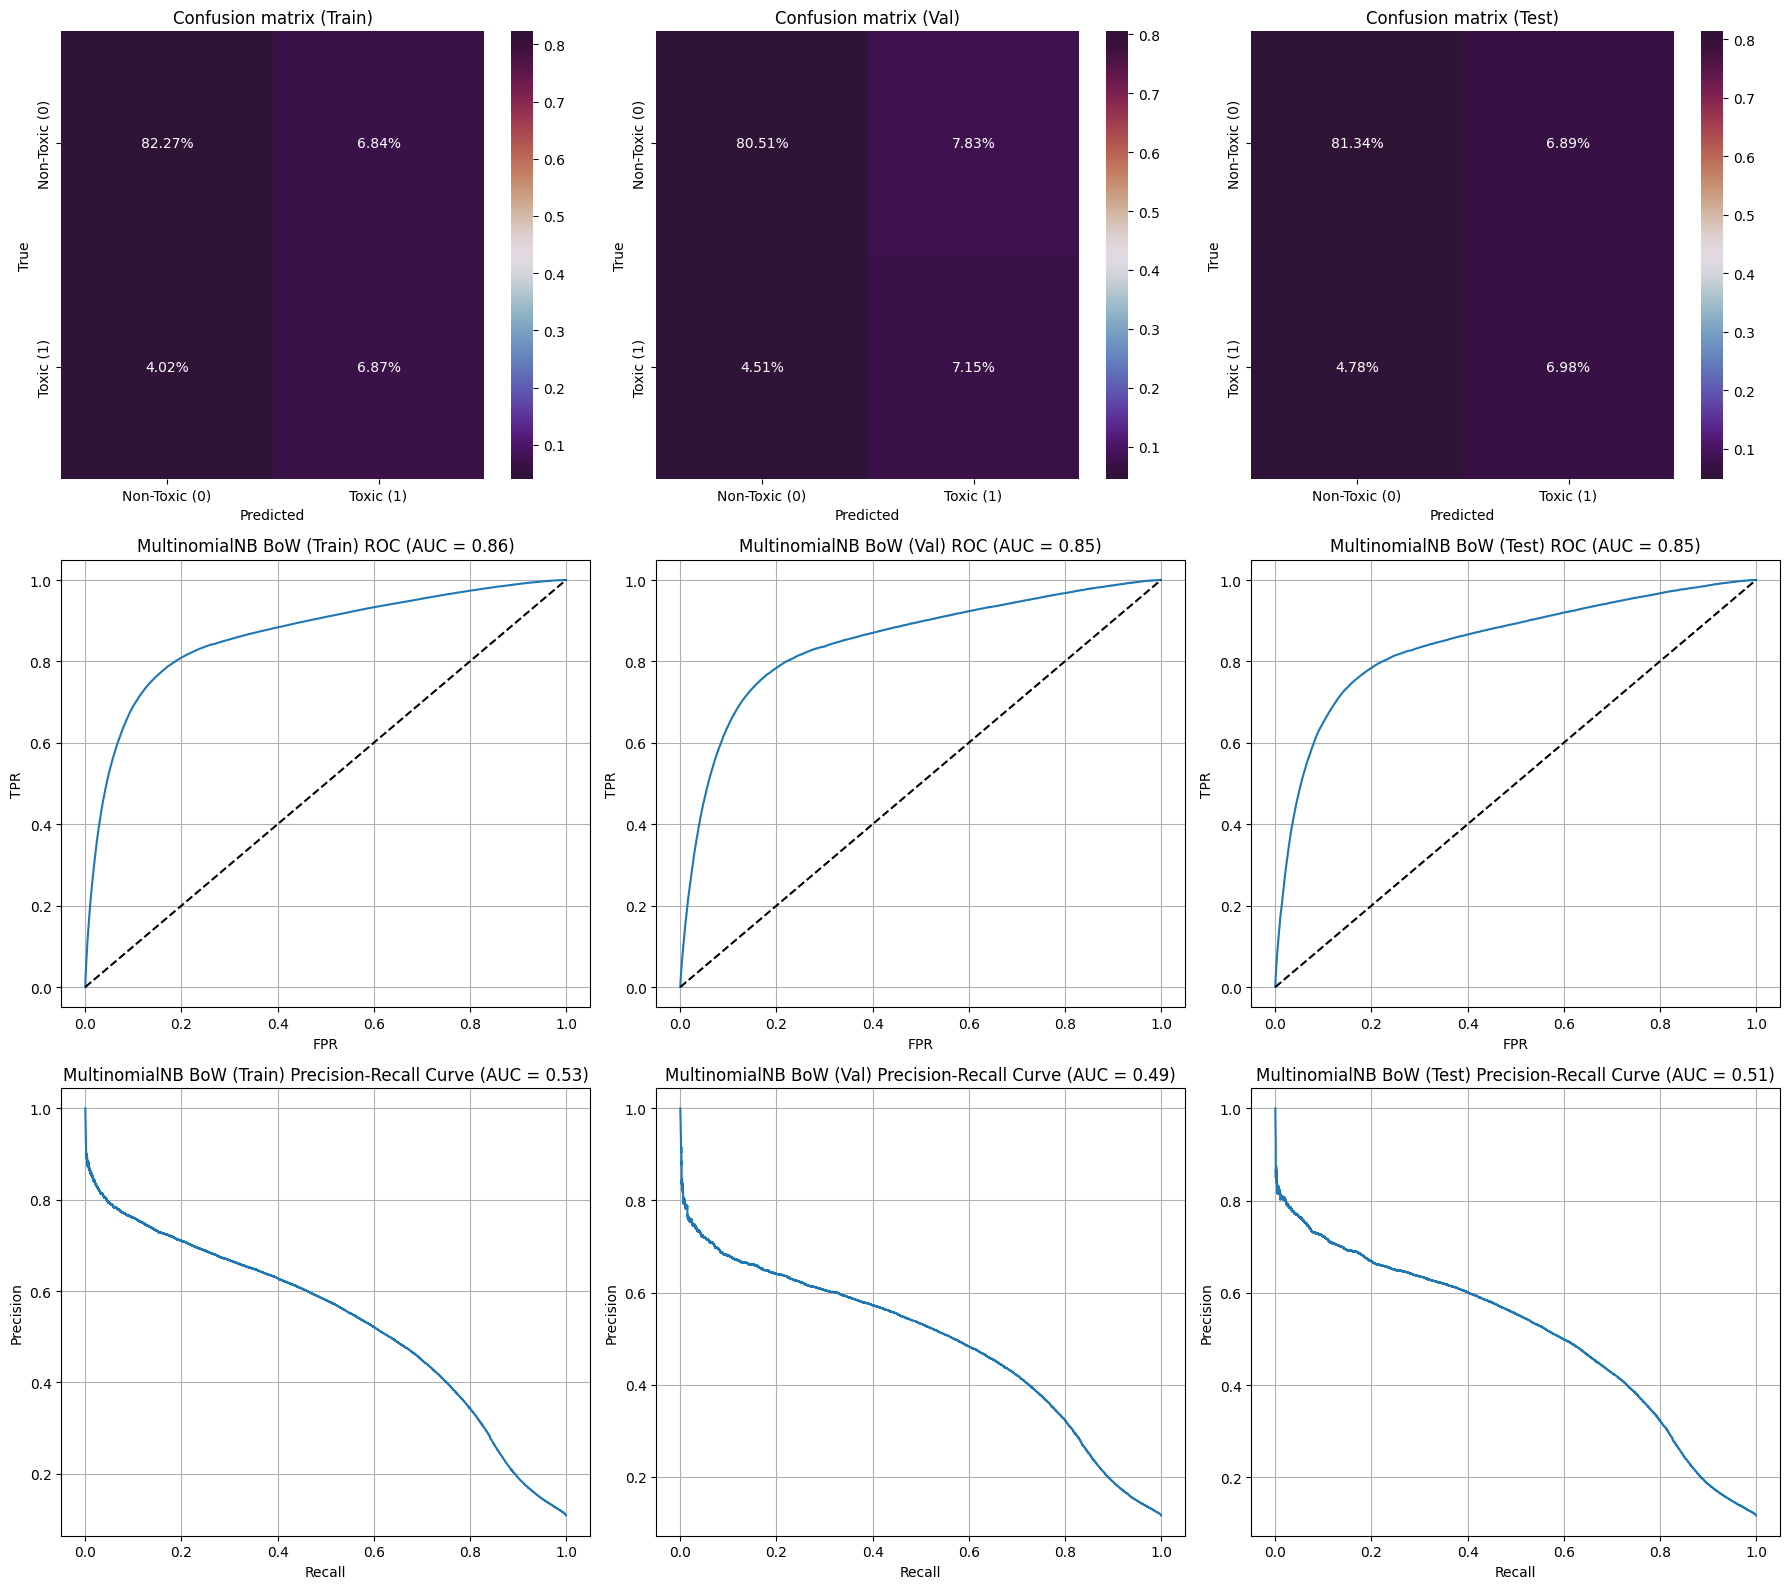

In [47]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_val=y_nb_bow_pred_val,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_val=y_nb_bow_pred_proba_val,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

##### Биграммы, триграммы

In [ ]:
X_train_bow_ngrams, X_val_bow_ngrams, X_test_bow_ngrams = get_bows(X_train, X_val, X_test, ngram_range=(2, 3))

In [ ]:
best_alpha = get_hyperparams(X_train_bow_ngrams, X_val_bow_ngrams, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_bow_ngrams_pred_train,
    y_nb_bow_ngrams_pred_val,
    y_nb_bow_ngrams_pred_test,
    y_nb_bow_ngrams_pred_proba_train,
    y_nb_bow_ngrams_pred_proba_val,
    y_nb_bow_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_bow_ngrams,
    X_val=X_val_bow_ngrams,
    X_test=X_test_bow_ngrams,
    y_train=y_train,
)

[I 2024-12-03 22:55:28,812] A new study created in memory with name: no-name-33ecba94-a376-47d6-9463-6845593c88cf
[I 2024-12-03 22:55:30,482] Trial 0 finished with value: 0.3661336977161009 and parameters: {'alpha': 0.053168283250376334}. Best is trial 0 with value: 0.3661336977161009.
[I 2024-12-03 22:55:31,943] Trial 1 finished with value: 0.36463423270306633 and parameters: {'alpha': 0.045828010193500524}. Best is trial 0 with value: 0.3661336977161009.
[I 2024-12-03 22:55:33,385] Trial 2 finished with value: 0.3570819415819771 and parameters: {'alpha': 0.032483400165232566}. Best is trial 0 with value: 0.3661336977161009.
[I 2024-12-03 22:55:34,832] Trial 3 finished with value: 0.3517185965538791 and parameters: {'alpha': 0.026562348828172364}. Best is trial 0 with value: 0.3661336977161009.
[I 2024-12-03 22:55:36,278] Trial 4 finished with value: 0.27762666543727815 and parameters: {'alpha': 0.3194043977178886}. Best is trial 0 with value: 0.3661336977161009.
[I 2024-12-03 22:55:3

MultinomialNB BoW

Precision		Recall			F1

Train: 0.96		Train: 0.99		Train: 0.97
Val: 0.46		Val: 0.31		Val: 0.37
Test: 0.47		Test: 0.29		Test: 0.36


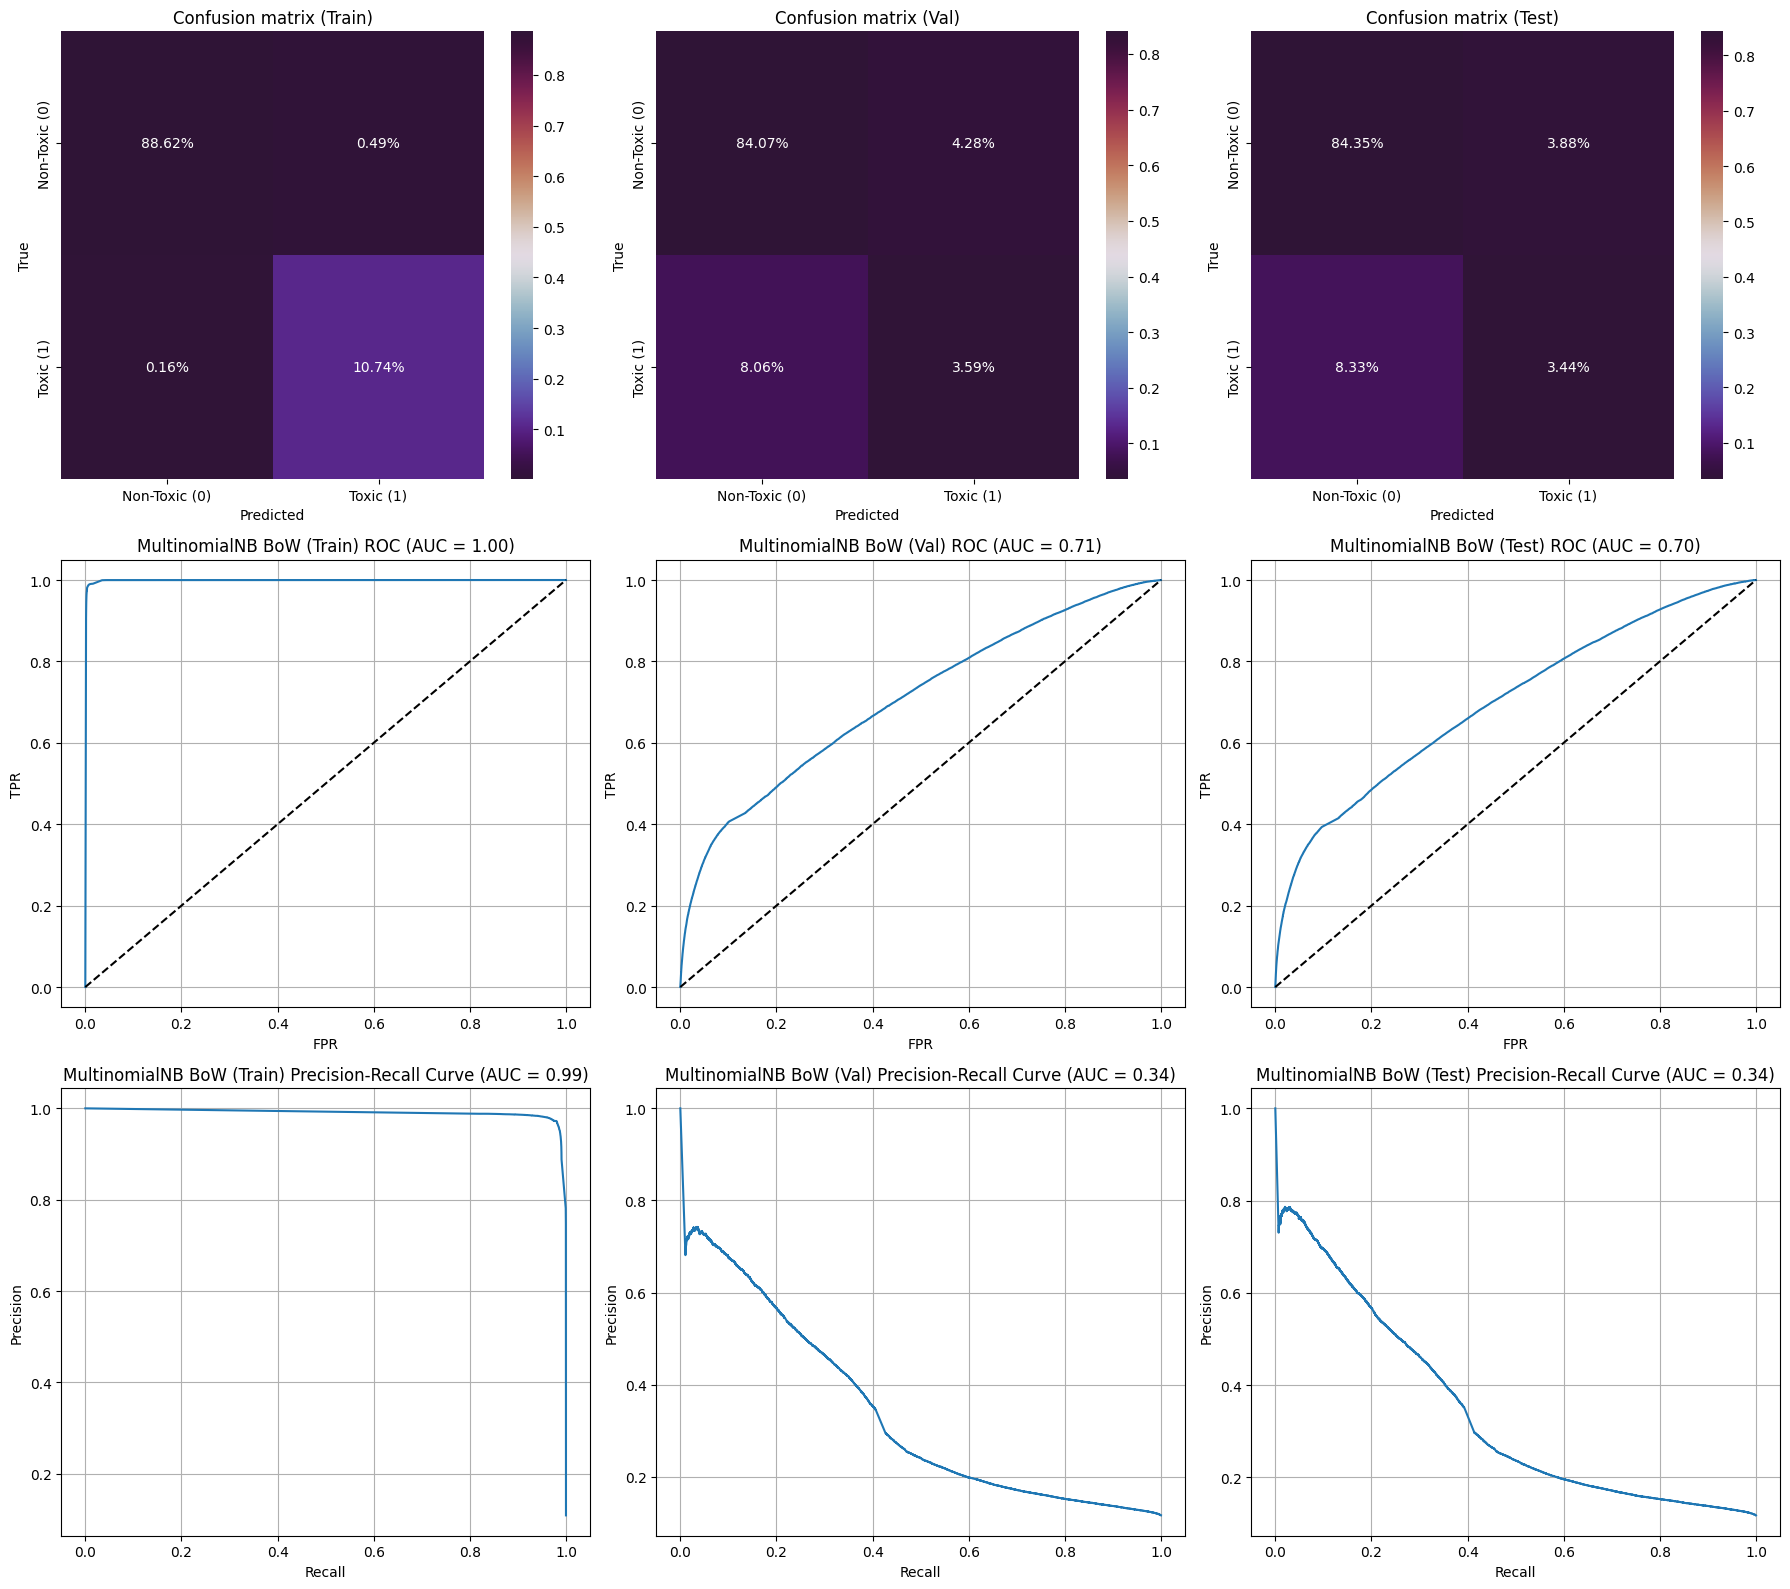

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_ngrams_pred_train,
    y_pred_val=y_nb_bow_ngrams_pred_val,
    y_pred_test=y_nb_bow_ngrams_pred_test,
    y_pred_proba_train=y_nb_bow_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_bow_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_bow_ngrams_pred_proba_test,
    title='MultinomialNB BoW'
)

#### Градиентный бустинг

In [22]:
best_cb_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, cb_objective, n_trials=5)
(
    y_cb_bow_pred_train,
    y_nb_bow_pred_val,
    y_cb_bow_pred_test,
    y_cb_bow_pred_proba_train,
    y_cb_bow_pred_proba_val,
    y_cb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CatBoostClassifier(**best_cb_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2024-12-04 16:31:46,832] A new study created in memory with name: no-name-29f9e5d2-7077-4566-ae8e-43f84f23047c
[I 2024-12-04 16:45:18,376] Trial 0 finished with value: 0.4257421355782012 and parameters: {'iterations': 439, 'depth': 5, 'learning_rate': 0.05748190694095087, 'l2_leaf_reg': 2.0189342170897135, 'border_count': 206, 'random_strength': 3.615924904116688, 'bagging_temperature': 0.5359708978844823}. Best is trial 0 with value: 0.4257421355782012.
[I 2024-12-04 17:00:19,386] Trial 1 finished with value: 0.4129527400026929 and parameters: {'iterations': 456, 'depth': 5, 'learning_rate': 0.048433986581448214, 'l2_leaf_reg': 8.638751542763357, 'border_count': 176, 'random_strength': 3.1898672040515645, 'bagging_temperature': 0.21533142127937532}. Best is trial 0 with value: 0.4257421355782012.
[I 2024-12-04 17:15:48,760] Trial 2 finished with value: 0.4732530324519994 and parameters: {'iterations': 384, 'depth': 7, 'learning_rate': 0.09261520564568308, 'l2_leaf_reg': 5.349795606

0:	learn: 0.6077401	total: 3.12s	remaining: 51m 3s
1:	learn: 0.5406626	total: 6.14s	remaining: 50m 7s
2:	learn: 0.4880528	total: 9.24s	remaining: 50m 16s
3:	learn: 0.4469525	total: 12.2s	remaining: 49m 38s
4:	learn: 0.4150721	total: 14.9s	remaining: 48m 22s
5:	learn: 0.3896692	total: 17.9s	remaining: 48m 32s
6:	learn: 0.3695196	total: 20.7s	remaining: 48m 1s
7:	learn: 0.3536230	total: 23.3s	remaining: 47m 14s
8:	learn: 0.3407265	total: 26s	remaining: 46m 50s
9:	learn: 0.3304582	total: 28.6s	remaining: 46m 21s
10:	learn: 0.3218358	total: 31.1s	remaining: 45m 44s
11:	learn: 0.3148876	total: 33.6s	remaining: 45m 19s
12:	learn: 0.3092108	total: 36.3s	remaining: 45m 8s
13:	learn: 0.3044491	total: 38.8s	remaining: 44m 43s
14:	learn: 0.3003860	total: 41.4s	remaining: 44m 25s
15:	learn: 0.2970571	total: 43.9s	remaining: 44m 9s
16:	learn: 0.2941236	total: 46.4s	remaining: 43m 52s
17:	learn: 0.2915001	total: 49.2s	remaining: 43m 54s
18:	learn: 0.2890427	total: 51.9s	remaining: 43m 51s
19:	learn:

CatBoost BoW

Precision		Recall			F1

Train: 0.80		Train: 0.45		Train: 0.58
Val: 0.78		Val: 0.43		Val: 0.56
Test: 0.79		Test: 0.43		Test: 0.56


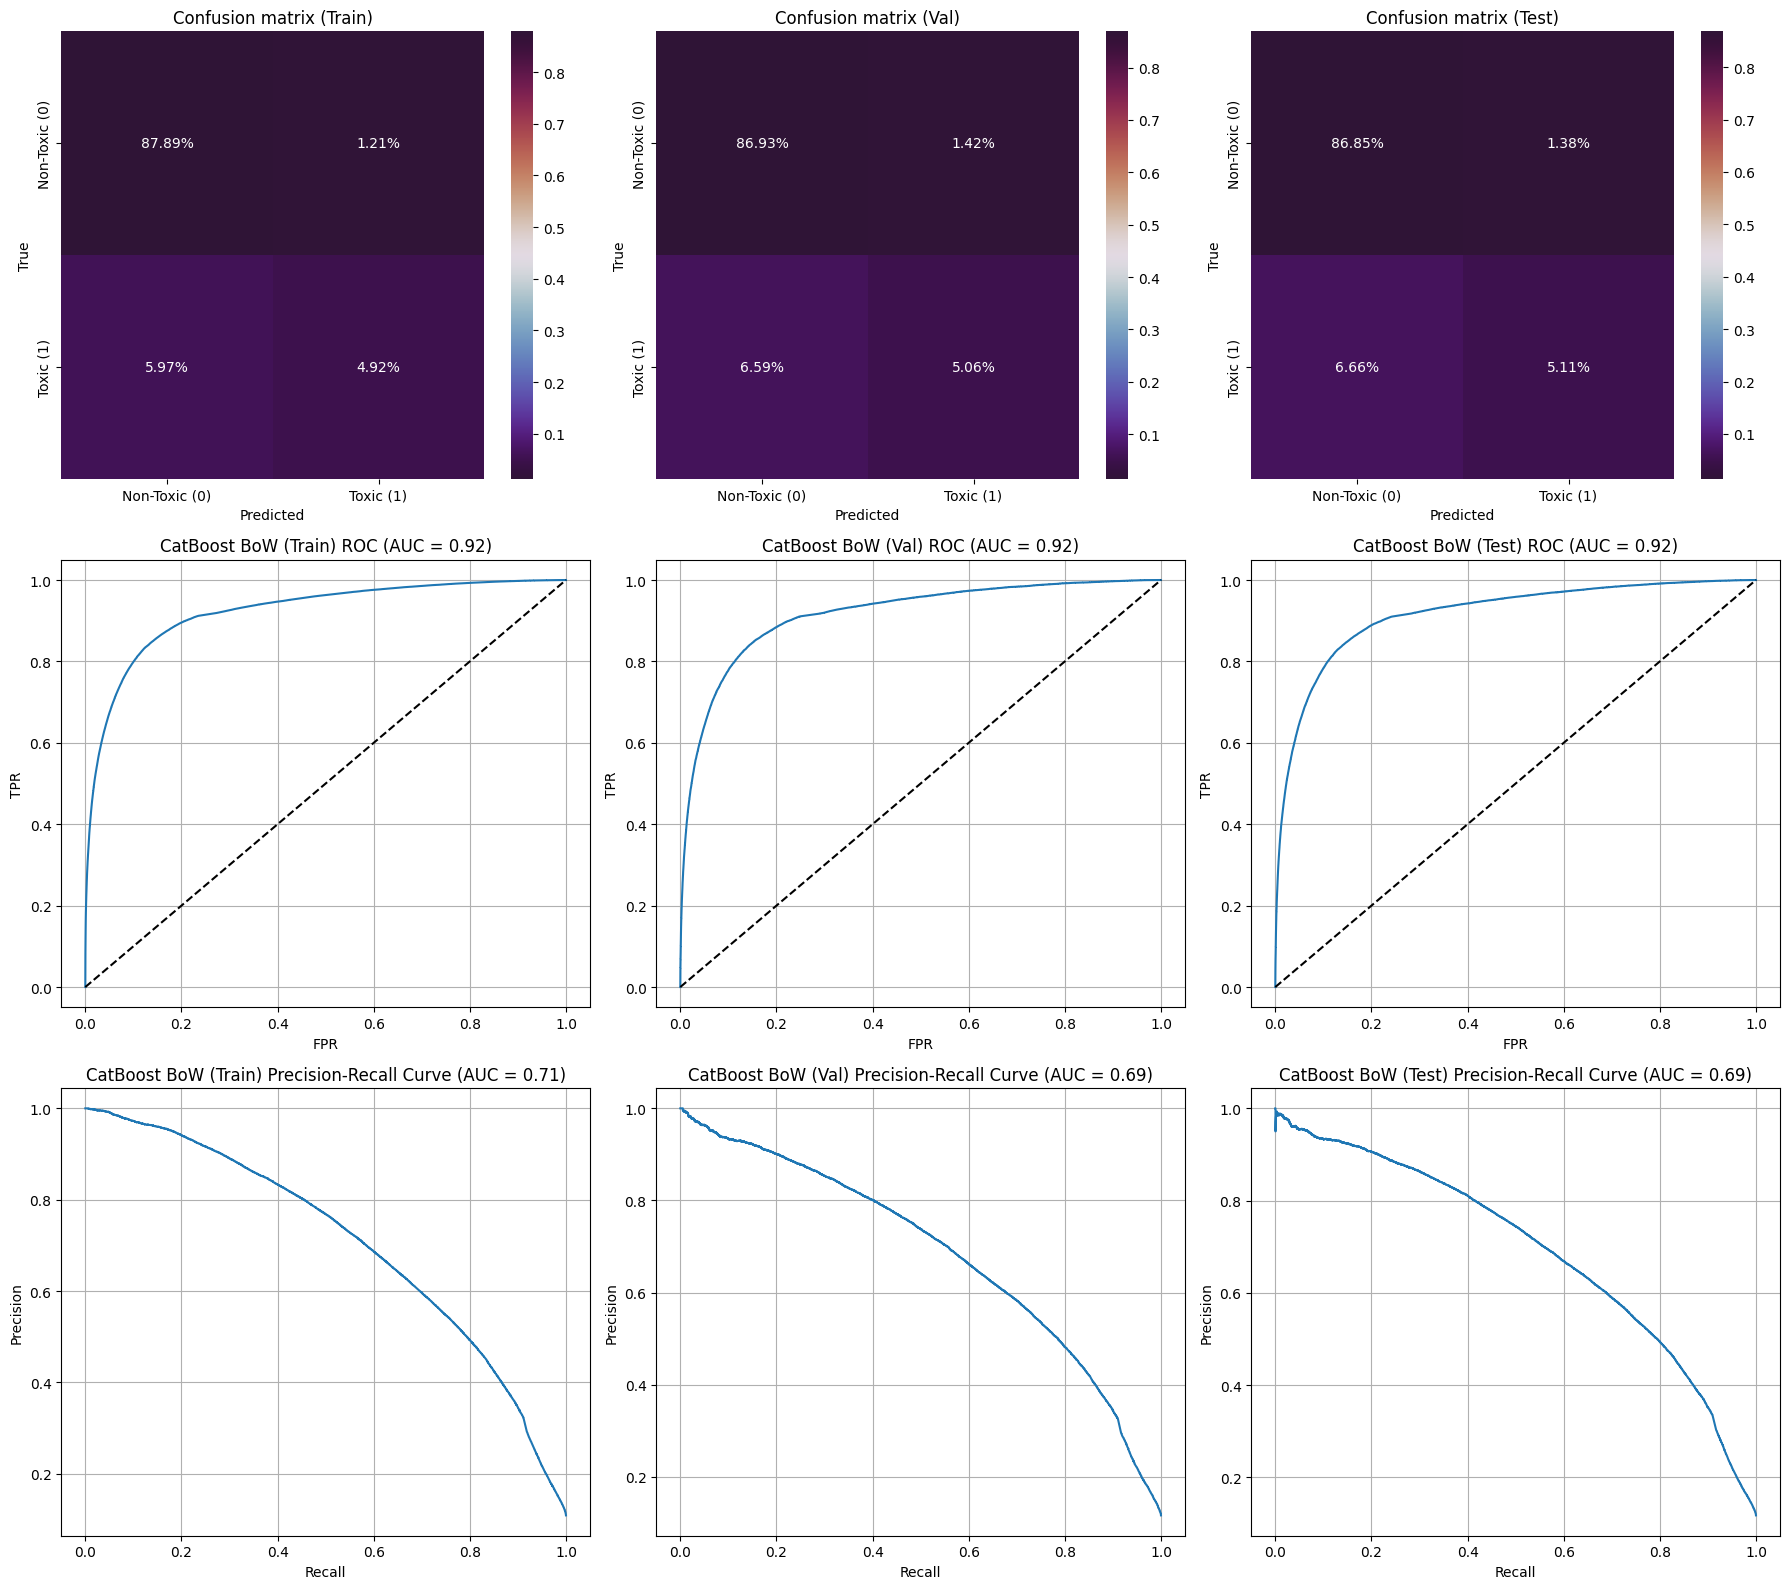

In [24]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_cb_bow_pred_train,
    y_pred_val=y_nb_bow_pred_val,
    y_pred_test=y_cb_bow_pred_test,
    y_pred_proba_train=y_cb_bow_pred_proba_train,
    y_pred_proba_val=y_cb_bow_pred_proba_val,
    y_pred_proba_test=y_cb_bow_pred_proba_test,
    title='CatBoost BoW'
)

### Обучение с TF-IDF

In [25]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = get_tfidf(X_train, X_val, X_test)

#### Логистическая регрессия

In [ ]:
(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.79		Train: 0.48		Train: 0.60
Val: 0.78		Val: 0.48		Val: 0.59
Test: 0.78		Test: 0.47		Test: 0.59


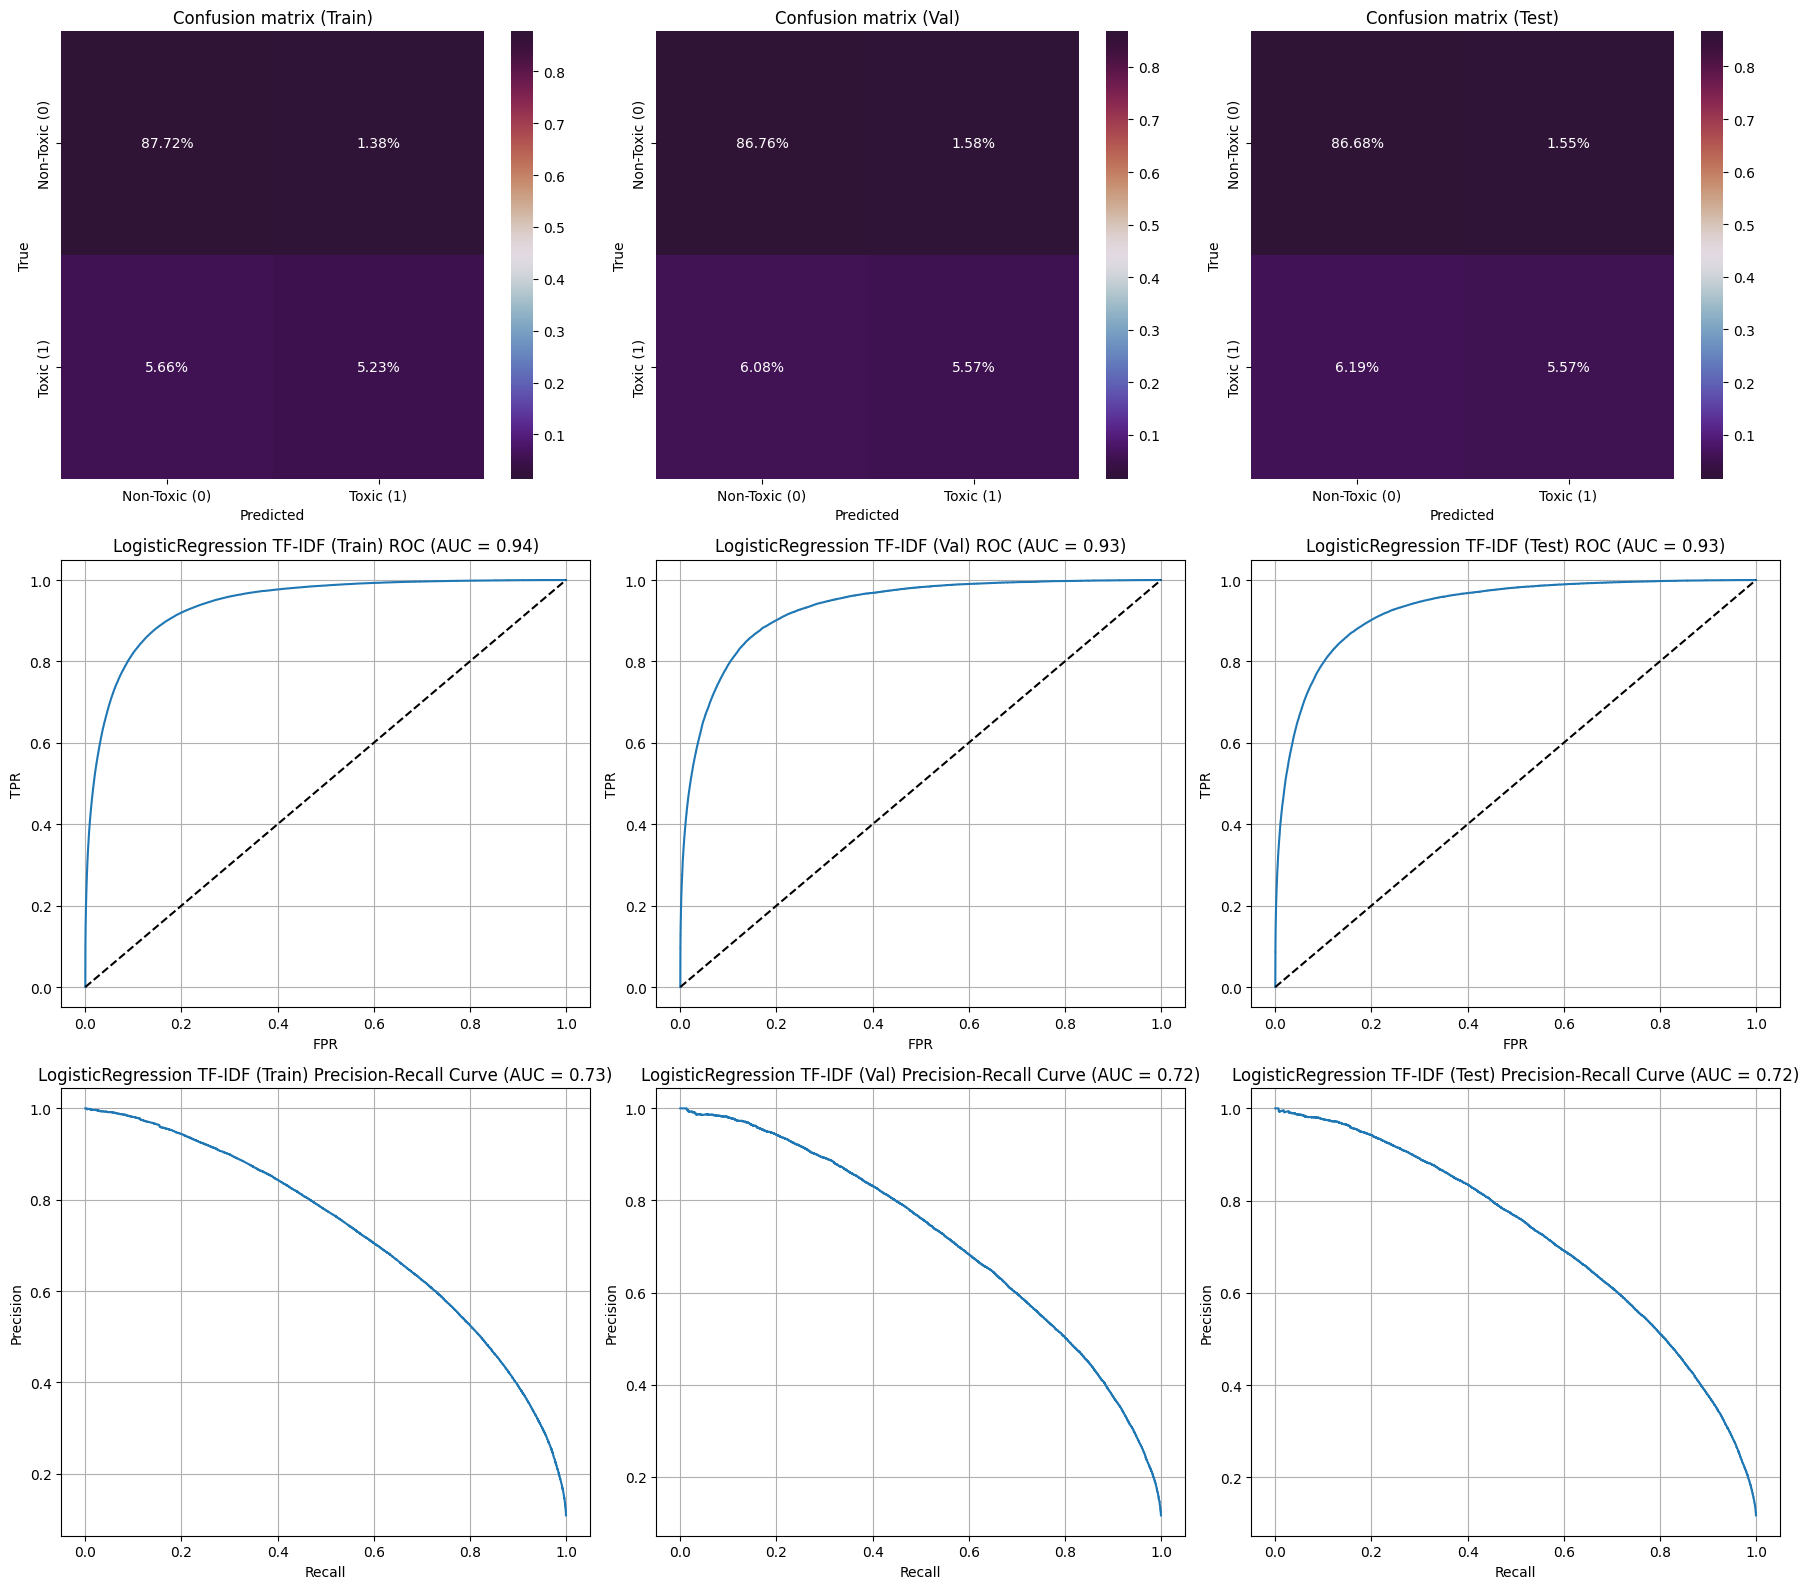

In [50]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_val=y_log_reg_tfidf_pred_val,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

#### SVM

In [ ]:
best_C = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, svc_objective, n_trials=20).get('C', 1)
(
    y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_val,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_val,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(C=best_C, dual=False),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_val=y_linear_svc_tfidf_pred_val,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

#### Наивный Байес

##### Слова

In [52]:
best_alpha = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_val,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2024-12-03 23:04:37,199] A new study created in memory with name: no-name-ffbfb2fd-8921-485e-b55a-ed9452a7b5ef
[I 2024-12-03 23:04:37,376] Trial 0 finished with value: 0.2218963575898819 and parameters: {'alpha': 0.12712954906430868}. Best is trial 0 with value: 0.2218963575898819.
[I 2024-12-03 23:04:37,526] Trial 1 finished with value: 0.241872161350748 and parameters: {'alpha': 0.015397574978093229}. Best is trial 1 with value: 0.241872161350748.
[I 2024-12-03 23:04:37,683] Trial 2 finished with value: 0.23751937984496124 and parameters: {'alpha': 0.04776219612926627}. Best is trial 1 with value: 0.241872161350748.
[I 2024-12-03 23:04:37,825] Trial 3 finished with value: 0.21501751428797178 and parameters: {'alpha': 0.16346645917325095}. Best is trial 1 with value: 0.241872161350748.
[I 2024-12-03 23:04:38,004] Trial 4 finished with value: 0.23630199032015944 and parameters: {'alpha': 0.05767060128001149}. Best is trial 1 with value: 0.241872161350748.
[I 2024-12-03 23:04:38,173]

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.94		Train: 0.21		Train: 0.35
Val: 0.82		Val: 0.14		Val: 0.24
Test: 0.83		Test: 0.13		Test: 0.22


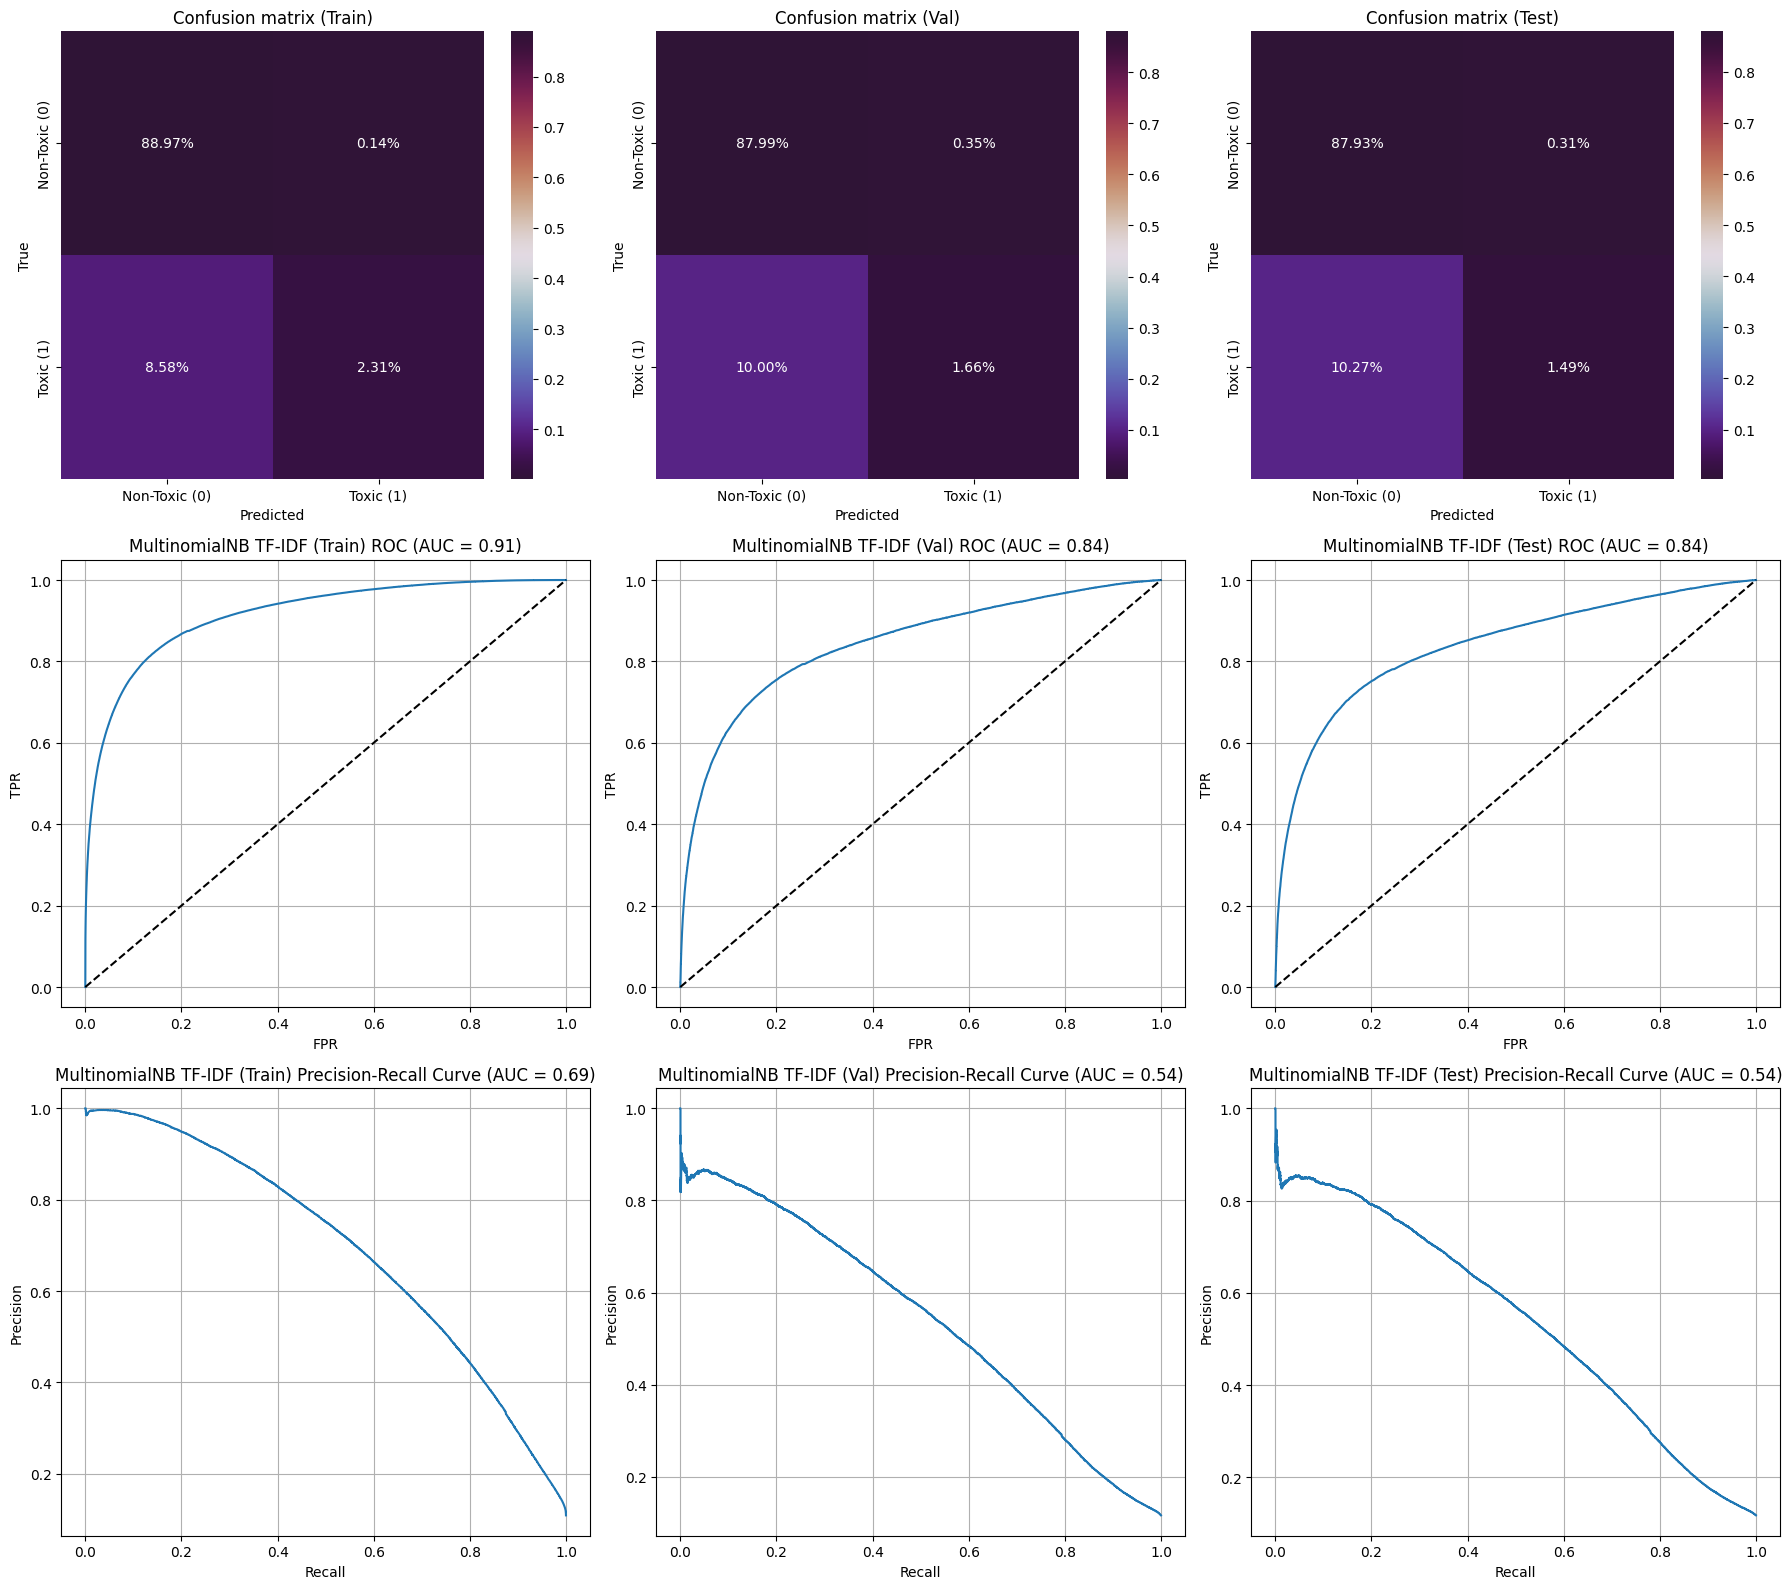

In [53]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_val=y_nb_tfidf_pred_val,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

##### Биграммы, триграммы

In [54]:
X_train_tfidf_ngrams, X_val_tfidf_ngrams, X_test_tfidf_ngrams = get_tfidf(X_train, X_val, X_test, ngram_range=(2, 3))

In [55]:
best_alpha = get_hyperparams(X_train_tfidf_ngrams, X_val_tfidf_ngrams, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_tfidf_ngrams_pred_train,
    y_nb_tfidf_ngrams_pred_val,
    y_nb_tfidf_ngrams_pred_test,
    y_nb_tfidf_ngrams_pred_proba_train,
    y_nb_tfidf_ngrams_pred_proba_val,
    y_nb_tfidf_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf_ngrams,
    X_val=X_val_tfidf_ngrams,
    X_test=X_test_tfidf_ngrams,
    y_train=y_train,
)

[I 2024-12-03 23:25:43,286] A new study created in memory with name: no-name-2fa84969-571f-4eb1-9810-07a18af8aef8
[I 2024-12-03 23:25:44,936] Trial 0 finished with value: 0.009564515646949816 and parameters: {'alpha': 0.5831959568631864}. Best is trial 0 with value: 0.009564515646949816.
[I 2024-12-03 23:25:46,290] Trial 1 finished with value: 0.17547080732308662 and parameters: {'alpha': 0.03466776300430236}. Best is trial 1 with value: 0.17547080732308662.
[I 2024-12-03 23:25:47,625] Trial 2 finished with value: 0.0356448476992871 and parameters: {'alpha': 0.20612773453518776}. Best is trial 1 with value: 0.17547080732308662.
[I 2024-12-03 23:25:48,987] Trial 3 finished with value: 0.017501041728674324 and parameters: {'alpha': 0.362613773047157}. Best is trial 1 with value: 0.17547080732308662.
[I 2024-12-03 23:25:50,385] Trial 4 finished with value: 0.007480326740672032 and parameters: {'alpha': 0.7466400981635497}. Best is trial 1 with value: 0.17547080732308662.
[I 2024-12-03 23:

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.98		Train: 0.99		Train: 0.99
Val: 0.57		Val: 0.17		Val: 0.26
Test: 0.59		Test: 0.16		Test: 0.25


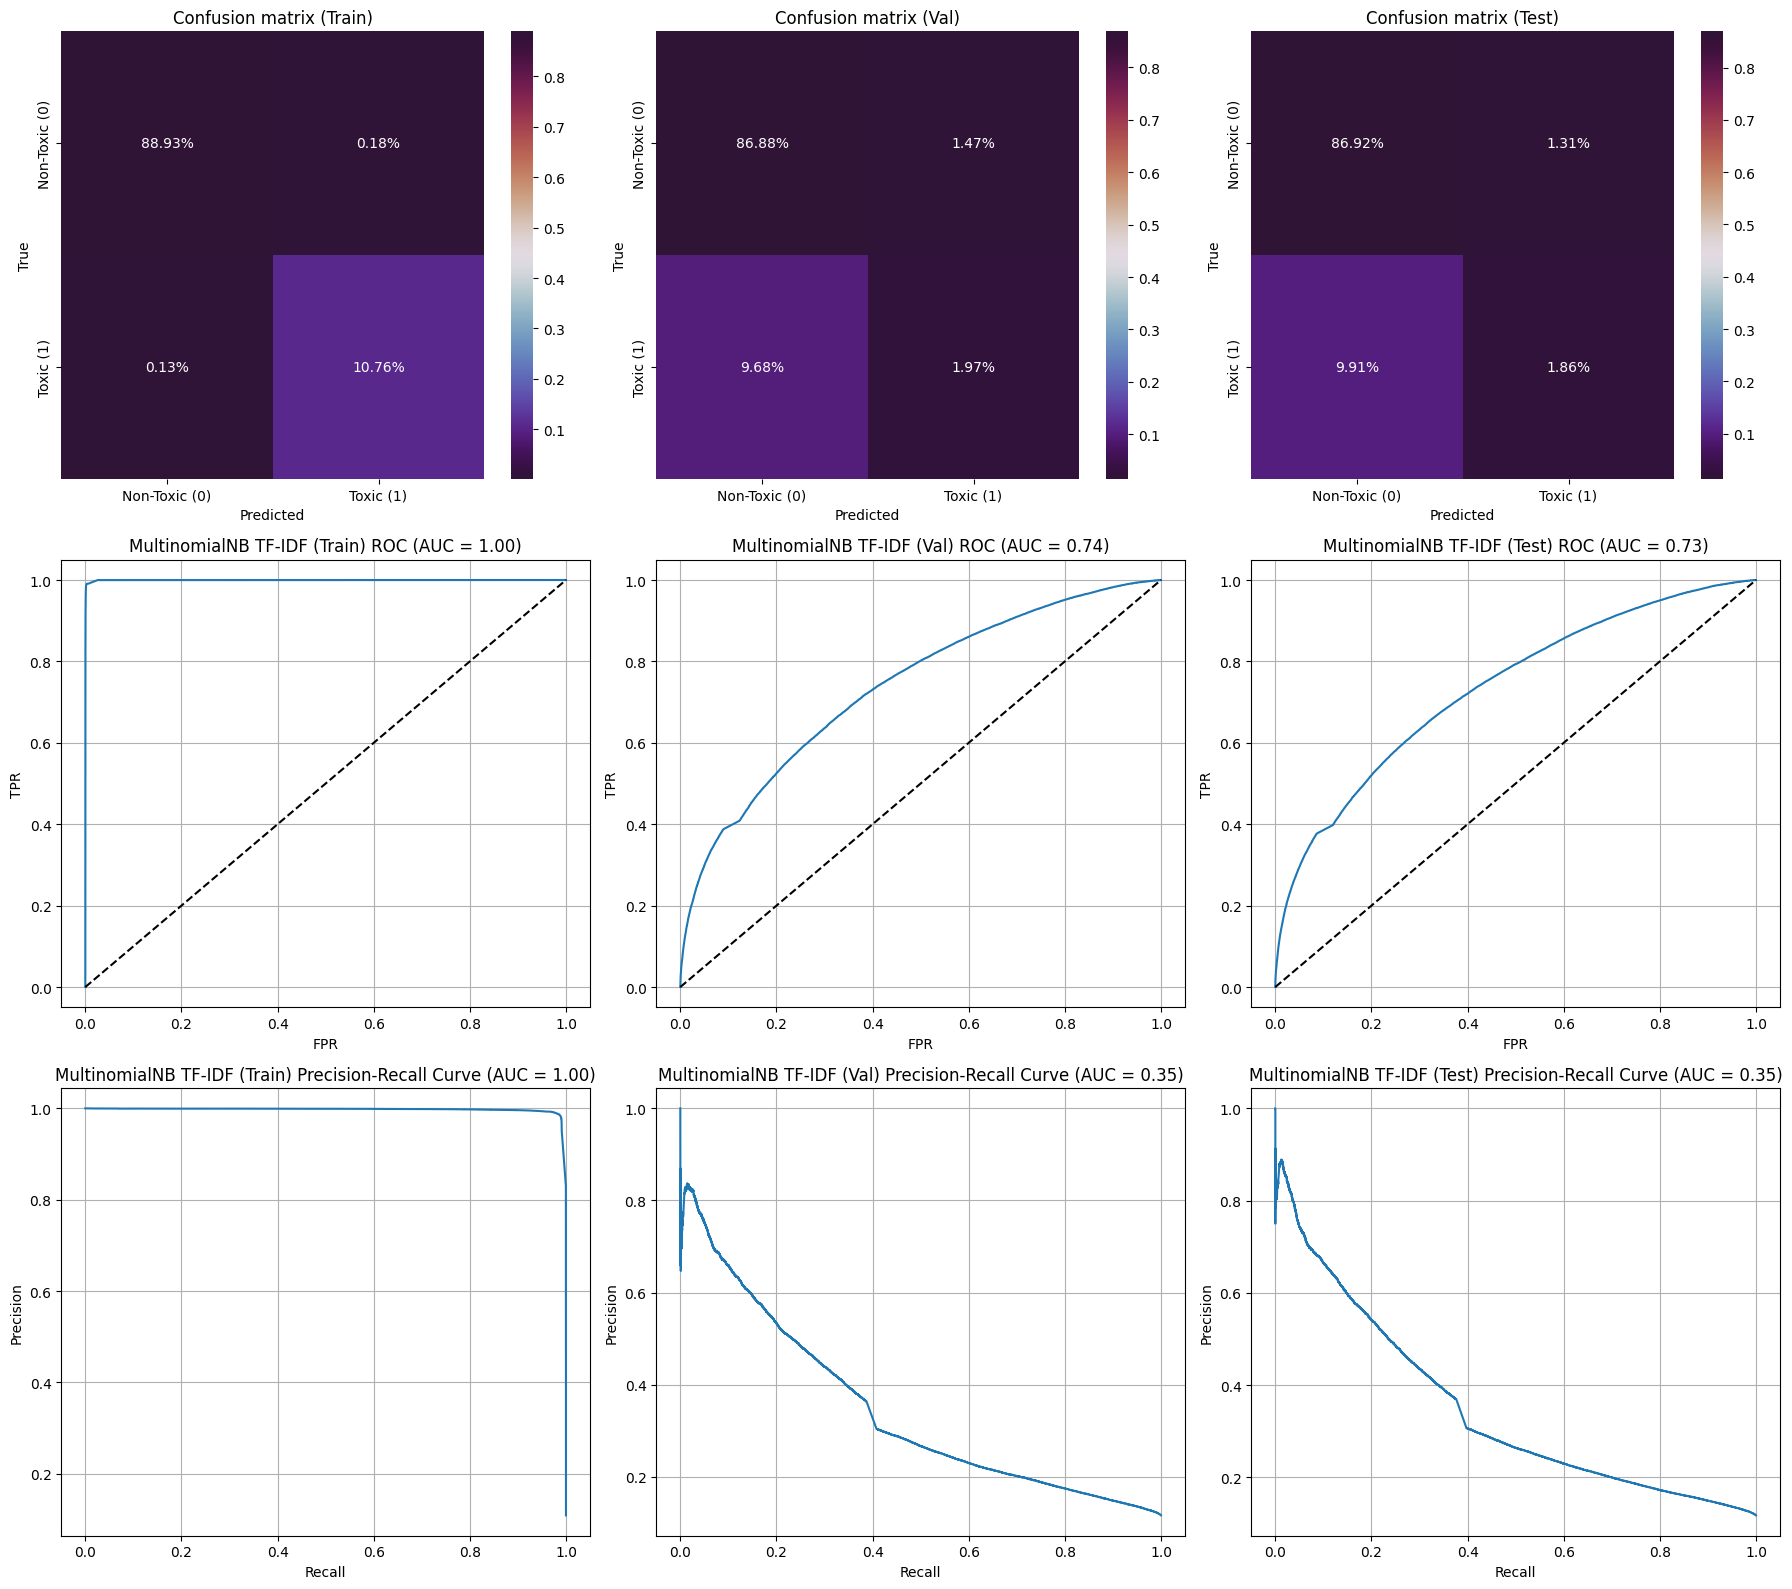

In [56]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_ngrams_pred_train,
    y_pred_val=y_nb_tfidf_ngrams_pred_val,
    y_pred_test=y_nb_tfidf_ngrams_pred_test,
    y_pred_proba_train=y_nb_tfidf_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_ngrams_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

#### Градиентный бустинг

In [ ]:
best_cb_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, cb_objective, n_trials=5)
(
    y_cb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_cb_tfidf_pred_test,
    y_cb_tfidf_pred_proba_train,
    y_cb_tfidf_pred_proba_val,
    y_cb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=CatBoostClassifier(**best_cb_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_cb_tfidf_pred_train,
    y_pred_val=y_nb_tfidf_pred_val,
    y_pred_test=y_cb_tfidf_pred_test,
    y_pred_proba_train=y_cb_tfidf_pred_proba_train,
    y_pred_proba_val=y_cb_tfidf_pred_proba_val,
    y_pred_proba_test=y_cb_tfidf_pred_proba_test,
    title='CatBoost TF-IDF'
)

## Multi-Label  классификация

In [57]:
labels = ['toxicity_b', 'obscene_b', 'identity_attack_b', 'insult_b', 'threat_b', 'sexual_explicit_b']

In [59]:
split_date = df.iloc[int(len(df) * 0.8)]['created_date']
split_date

Timestamp('2017-09-03 13:54:26.194849+0000', tz='UTC')

In [60]:
train_val_df = df[df['created_date'] <= split_date]
test_df = df[df['created_date'] > split_date]

In [61]:
X_test = test_df['ctws']
y_test = test_df[labels]

In [62]:
split_date = train_val_df.iloc[int(len(train_val_df) * 0.8)]['created_date']
split_date

Timestamp('2017-07-06 03:02:41.334553+0000', tz='UTC')

In [63]:
train_df = train_val_df[train_val_df['created_date'] <= split_date]
val_df = train_val_df[train_val_df['created_date'] > split_date]

In [64]:
X_train = train_df['ctws']
y_train = train_df[labels]

In [65]:
X_val = val_df['ctws']
y_val= val_df[labels]

In [66]:
y_train.mean(), y_test.mean(), y_val.mean()

(toxicity_b          0.11
 obscene_b           0.01
 identity_attack_b   0.01
 insult_b            0.08
 threat_b            0.00
 sexual_explicit_b   0.00
 dtype: float64,
 toxicity_b          0.12
 obscene_b           0.01
 identity_attack_b   0.02
 insult_b            0.09
 threat_b            0.00
 sexual_explicit_b   0.01
 dtype: float64,
 toxicity_b          0.12
 obscene_b           0.01
 identity_attack_b   0.02
 insult_b            0.09
 threat_b            0.00
 sexual_explicit_b   0.00
 dtype: float64)

In [ ]:
from sklearn.metrics import classification_report

def train_and_predict_toxicity_multilabel(model, X_train, X_val, X_test, y_train):
    ovr = OneVsRestClassifier(model, n_jobs=-1)
    ovr.fit(X_train, y_train)

    y_pred_train = ovr.predict(X_train)
    y_pred_val = ovr.predict(X_val)
    y_pred_test = ovr.predict(X_test)

    return y_pred_train, y_pred_val, y_pred_test

def show_classification_report(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, target_names, title):
    report_train = classification_report(y_train, y_pred_train, target_names=target_names, zero_division=0, output_dict=True)
    report_val = classification_report(y_val, y_pred_val, target_names=target_names, zero_division=0, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, target_names=target_names, zero_division=0, output_dict=True)

    report_train_df = pd.DataFrame(report_train).transpose()
    report_val_df = pd.DataFrame(report_val).transpose()
    report_test_df = pd.DataFrame(report_test).transpose()

    def display_tables_in_row(df1, df2, df3, titles):
        html = f"""
        <div style="display: flex; justify-content: space-between;">
            <div style="flex: 1; padding: 10px;">
                <h3>{titles[0]}</h3>
                {df1.to_html()}
            </div>
            <div style="flex: 1; padding: 10px;">
                <h3>{titles[1]}</h3>
                {df2.to_html()}
            </div>
            <div style="flex: 1; padding: 10px;">
                <h3>{titles[2]}</h3>
                {df3.to_html()}
            </div>
        </div>
        """
        display(HTML(html))
    
    print(f"{title}\n")

    print("METRICS PER CLASS\n")
    display_tables_in_row(
        report_train_df.iloc[:-4, :],
        report_val_df.iloc[:-4, :],
        report_test_df.iloc[:-4, :],
        ["Train:", "Val:", "Test:"]
    )

    print("\nOVERALL METRICS\n")
    display_tables_in_row(
        report_train_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']),
        report_val_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']),
        report_test_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']),
        ["Train:", "Val:", "Test:"]
    )

    def show_heatmap(report_df, ax, model_name, sample_name):
        heatmap_df = report_df.iloc[:-4, :]
        
        sns.heatmap(heatmap_df.iloc[:, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=True, linewidths=0.5, ax=ax)
        ax.set_title(f"{model_name} Classification Report Heatmap ({sample_name})", fontsize=16)
        ax.set_ylabel("Classes", fontsize=12)
        ax.set_xlabel("Metrics", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    
    _, axes = plt.subplots(1, 3, figsize=(26, 7))
    
    show_heatmap(report_train_df, axes[0], title, "Train")
    show_heatmap(report_val_df, axes[1], title, "Val")
    show_heatmap(report_test_df, axes[2], title, "Test")

    plt.tight_layout()
    plt.show()

# def train_and_predict_toxicity_multilabel(model, X_train, X_test, y_train):
#     ovr = OneVsRestClassifier(model, n_jobs=-1)
#     ovr.fit(X_train, y_train)

#     y_pred_train = ovr.predict(X_train)
#     y_pred_test = ovr.predict(X_test)

#     if hasattr(model, 'predict_proba'):
#         # Вероятности для положительного класса
#         y_pred_proba_train = ovr.predict_proba(X_train)[:, 1]
#         y_pred_proba_test = ovr.predict_proba(X_test)[:, 1]
#     else:
#         y_pred_proba_train = None
#         y_pred_proba_test = None

#     return y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test

# def show_classification_report(y_train, y_test, y_pred_train, y_pred_test, y_pred_proba_train, y_pred_proba_test, target_names, title):
#     report_train = classification_report(y_train, y_pred_train, target_names=target_names, zero_division=0, output_dict=True)
#     report_test = classification_report(y_test, y_pred_test, target_names=target_names, zero_division=0, output_dict=True)

#     report_train_df = pd.DataFrame(report_train).transpose()
#     report_test_df = pd.DataFrame(report_test).transpose()

#     print(f"{title}\n")

#     print("METRICS PER CLASS\n")
#     print("Train:")
#     display(report_train_df.iloc[:-4, :])
#     print("\nTest:")
#     display(report_test_df.iloc[:-4, :])

#     print("\nOVERALL METRICS\n")
#     print("Train:")
#     display(report_train_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']))
#     print("\nTest:")
#     display(report_test_df.loc[["micro avg", "macro avg", "weighted avg", "samples avg"]].drop(columns=['support']))

#     def show_heatmap(report_df, ax, model_name, sample_name):
#         heatmap_df = report_df.iloc[:-4, :]
        
#         sns.heatmap(heatmap_df.iloc[:, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=True, linewidths=0.5, ax=ax)
#         ax.set_title(f"{model_name} Classification Report Heatmap ({sample_name})", fontsize=16)
#         ax.set_ylabel("Classes", fontsize=12)
#         ax.set_xlabel("Metrics", fontsize=12)
#         ax.tick_params(axis='x', rotation=45)
#         ax.tick_params(axis='y', rotation=0)
    
#     def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
#         fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
#         auc = roc_auc_score(y_true, y_pred_proba, average='micro')

#         ax.plot(fpr, tpr)
#         ax.plot([0, 1], [0, 1], 'k--')
#         ax.set_xlabel('FPR')
#         ax.set_ylabel('TPR')
#         ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
#         ax.grid(True)
    
#     def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
#         precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred_proba.ravel())
#         auc_pr = auc(recall, precision)

#         ax.plot(recall, precision)
#         ax.set_xlabel('Recall')
#         ax.set_ylabel('Precision')
#         ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
#         ax.grid(True)

#     if y_pred_proba_train is not None and y_pred_proba_test is not None:
#         _, axs = plt.subplots(3, 2, figsize=(16, 18))

#         show_heatmap(report_train_df, axs[0, 0], title, "Train")
#         show_heatmap(report_test_df, axs[0, 1], title, "Test")

#         show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
#         show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 1])

#         show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
#         show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 1])
#     else:
#         _, axs = plt.subplots(1, 2, figsize=(14, 6))
        
#         show_heatmap(report_train_df, axs[0], title, "Train")
#         show_heatmap(report_test_df, axs[1], title, "Test")

#     plt.tight_layout()
#     plt.show()

In [ ]:
def multi_label_svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    svc = LinearSVC(C=C, dual=False),
    clf = OneVsRestClassifier(svc, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_val)
    return f1_score(y_val, y_pred, average='micro')

def multi_label_mnb_objective(trial, X_train, X_val, y_train, y_val):
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)
    
    mnb = MultinomialNB(alpha=alpha)
    clf = OneVsRestClassifier(mnb, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_val)
    return f1_score(y_val, y_pred, average='micro')

### Обучение с мешком слов

#### Логистическая регрессия

In [71]:
y_log_reg_bow_pred_train, y_log_reg_bow_pred_val, y_log_reg_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

# (
#     y_log_reg_bow_pred_train,
#     y_log_reg_bow_pred_test,
#     y_log_reg_bow_pred_proba_train,
#     y_log_reg_bow_pred_proba_test
# ) = train_and_predict_toxicity_multilabel(
#     model=LogisticRegression(max_iter=1000),
#     X_train=X_train_bow,
#     X_test=X_test_bow,
#     y_train=y_train,
# )

Multi-Label LogisticRegression BoW

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.81,0.53,0.64,124469.00
obscene_b,0.76,0.49,0.59,8816.00
identity_attack_b,0.69,0.29,0.40,14574.00
insult_b,0.81,0.56,0.66,93907.00
threat_b,0.44,0.09,0.15,4892.00
sexual_explicit_b,0.69,0.33,0.45,4864.00
,precision,recall,f1-score,support
toxicity_b,0.74,0.48,0.58,33287.00
obscene_b,0.57,0.36,0.44,2062.00
identity_attack_b,0.44,0.21,0.28,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.80,0.51,0.62
macro avg,0.70,0.38,0.48
weighted avg,0.79,0.51,0.62
samples avg,0.06,0.06,0.06
,precision,recall,f1-score
micro avg,0.72,0.46,0.56
macro avg,0.54,0.31,0.39
weighted avg,0.71,0.46,0.55
samples avg,0.06,0.05,0.05
,precision,recall,f1-score


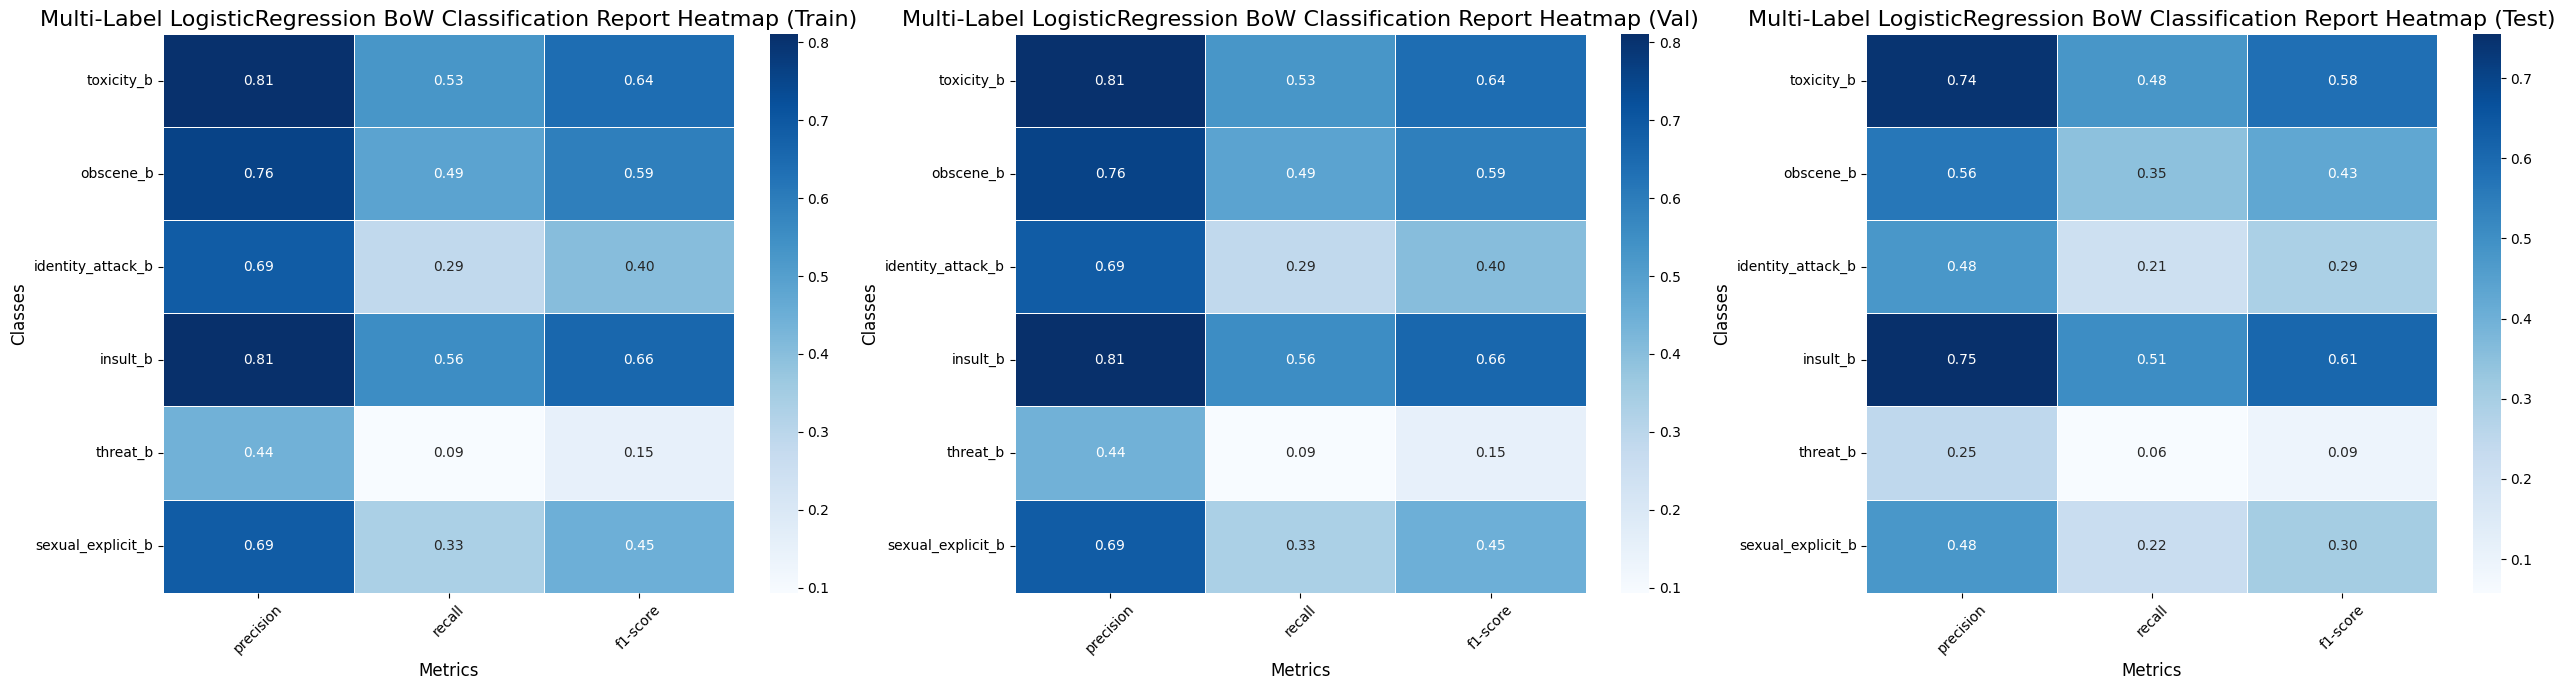

In [92]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_train.columns,
    'Multi-Label LogisticRegression BoW'
)

# show_classification_report(
#     y_train,
#     y_test,
#     y_log_reg_bow_pred_train,
#     y_log_reg_bow_pred_test,
#     y_log_reg_bow_pred_proba_train,
#     y_log_reg_bow_pred_proba_test,
#     y_train.columns,
#     'Multi-Label LogisticRegression BoW'
# )

#### SVM

In [ ]:
best_C = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, multi_label_svc_objective, n_trials=20).get('C', 1)

y_svm_bow_pred_train, y_svm_bow_pred_val, y_svm_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=LinearSVC(C=best_C, dual=False),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_svm_bow_pred_train,
    y_svm_bow_pred_val,
    y_svm_bow_pred_test,
    y_train.columns,
    'Multi-Label SVM BoW'
)

#### Наивный Байес

##### Слова

In [93]:
best_alpha = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, multi_label_mnb_objective).get('alpha', 1)

y_nb_bow_pred_train, y_nb_bow_pred_val, y_nb_bow_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2024-12-03 23:48:46,457] A new study created in memory with name: no-name-cdcbbbca-39bd-4593-9292-9491de85a62a
[I 2024-12-03 23:48:49,653] Trial 0 finished with value: 0.48852801132206725 and parameters: {'alpha': 0.36595132147769754}. Best is trial 0 with value: 0.48852801132206725.
[I 2024-12-03 23:48:51,515] Trial 1 finished with value: 0.4925019926719104 and parameters: {'alpha': 0.4896253256249334}. Best is trial 1 with value: 0.4925019926719104.
[I 2024-12-03 23:48:53,502] Trial 2 finished with value: 0.47221135685468096 and parameters: {'alpha': 0.10709982716896792}. Best is trial 1 with value: 0.4925019926719104.
[I 2024-12-03 23:48:55,324] Trial 3 finished with value: 0.4695540213554732 and parameters: {'alpha': 0.07911334450715735}. Best is trial 1 with value: 0.4925019926719104.
[I 2024-12-03 23:48:57,198] Trial 4 finished with value: 0.4986134295406817 and parameters: {'alpha': 0.9016040881049345}. Best is trial 4 with value: 0.4986134295406817.
[I 2024-12-03 23:48:58,42

Multi-Label MultinomialNB BoW

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.50,0.63,0.56,124469.00
obscene_b,0.26,0.12,0.16,8816.00
identity_attack_b,0.31,0.40,0.35,14574.00
insult_b,0.50,0.61,0.55,93907.00
threat_b,0.07,0.02,0.03,4892.00
sexual_explicit_b,0.23,0.11,0.15,4864.00
,precision,recall,f1-score,support
toxicity_b,0.48,0.61,0.54,33287.00
obscene_b,0.29,0.07,0.11,2062.00
identity_attack_b,0.32,0.36,0.34,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.48,0.57,0.52
macro avg,0.31,0.31,0.30
weighted avg,0.47,0.57,0.51
samples avg,0.07,0.06,0.06
,precision,recall,f1-score
micro avg,0.46,0.54,0.50
macro avg,0.30,0.28,0.27
weighted avg,0.45,0.54,0.49
samples avg,0.07,0.06,0.06
,precision,recall,f1-score


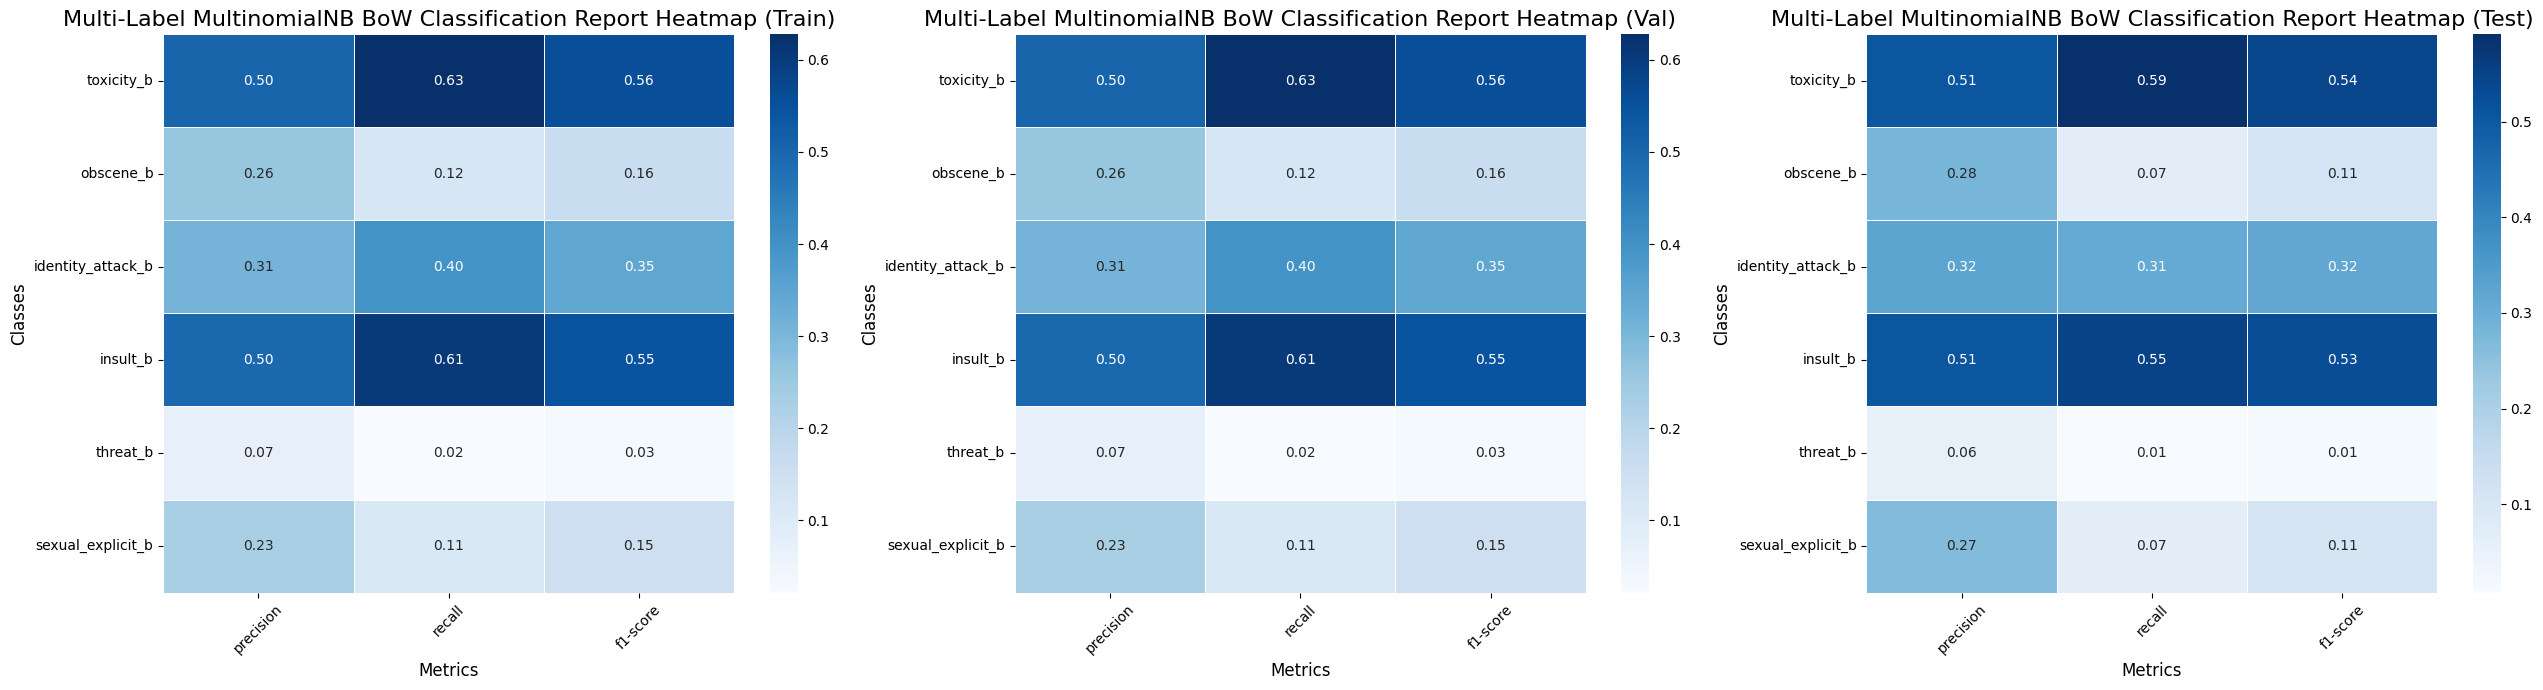

In [94]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_nb_bow_pred_train,
    y_nb_bow_pred_val,
    y_nb_bow_pred_test,
    y_train.columns,
    'Multi-Label MultinomialNB BoW'
)

##### Биграммы, триграммы

In [97]:
best_alpha = get_hyperparams(X_train_bow_ngrams, X_val_bow_ngrams, y_train, y_val, multi_label_mnb_objective).get('alpha', 1)

y_nb_bow_ngrams_pred_train, y_nb_bow_ngrams_pred_val, y_nb_bow_ngrams_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_bow_ngrams,
    X_val=X_val_bow_ngrams,
    X_test=X_test_bow_ngrams,
    y_train=y_train,
)

[I 2024-12-04 00:15:37,947] A new study created in memory with name: no-name-67785fbc-a220-4d7d-ae03-080b2f4e512b
[I 2024-12-04 00:15:57,659] Trial 0 finished with value: 0.14125924831818243 and parameters: {'alpha': 0.6009186970251835}. Best is trial 0 with value: 0.14125924831818243.
[I 2024-12-04 00:16:16,107] Trial 1 finished with value: 0.22087417153877137 and parameters: {'alpha': 0.341065872415802}. Best is trial 1 with value: 0.22087417153877137.
[I 2024-12-04 00:16:33,342] Trial 2 finished with value: 0.291237890204521 and parameters: {'alpha': 0.179173891587091}. Best is trial 2 with value: 0.291237890204521.
[I 2024-12-04 00:16:50,550] Trial 3 finished with value: 0.30829095550843094 and parameters: {'alpha': 0.14128379878317784}. Best is trial 3 with value: 0.30829095550843094.
[I 2024-12-04 00:17:07,576] Trial 4 finished with value: 0.10483356006552097 and parameters: {'alpha': 0.8203941210623115}. Best is trial 3 with value: 0.30829095550843094.
[I 2024-12-04 00:17:24,577

Multi-Label MultinomialNB BoW

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.96,0.99,0.97,124469.00
obscene_b,0.87,0.98,0.92,8816.00
identity_attack_b,0.81,0.99,0.89,14574.00
insult_b,0.95,0.99,0.97,93907.00
threat_b,0.66,0.95,0.78,4892.00
sexual_explicit_b,0.71,0.99,0.83,4864.00
,precision,recall,f1-score,support
toxicity_b,0.45,0.31,0.37,33287.00
obscene_b,0.36,0.04,0.08,2062.00
identity_attack_b,0.41,0.16,0.23,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.93,0.98,0.96
macro avg,0.83,0.98,0.89
weighted avg,0.93,0.98,0.96
samples avg,0.11,0.11,0.11
,precision,recall,f1-score
micro avg,0.44,0.26,0.33
macro avg,0.39,0.14,0.19
weighted avg,0.44,0.26,0.32
samples avg,0.04,0.03,0.03
,precision,recall,f1-score


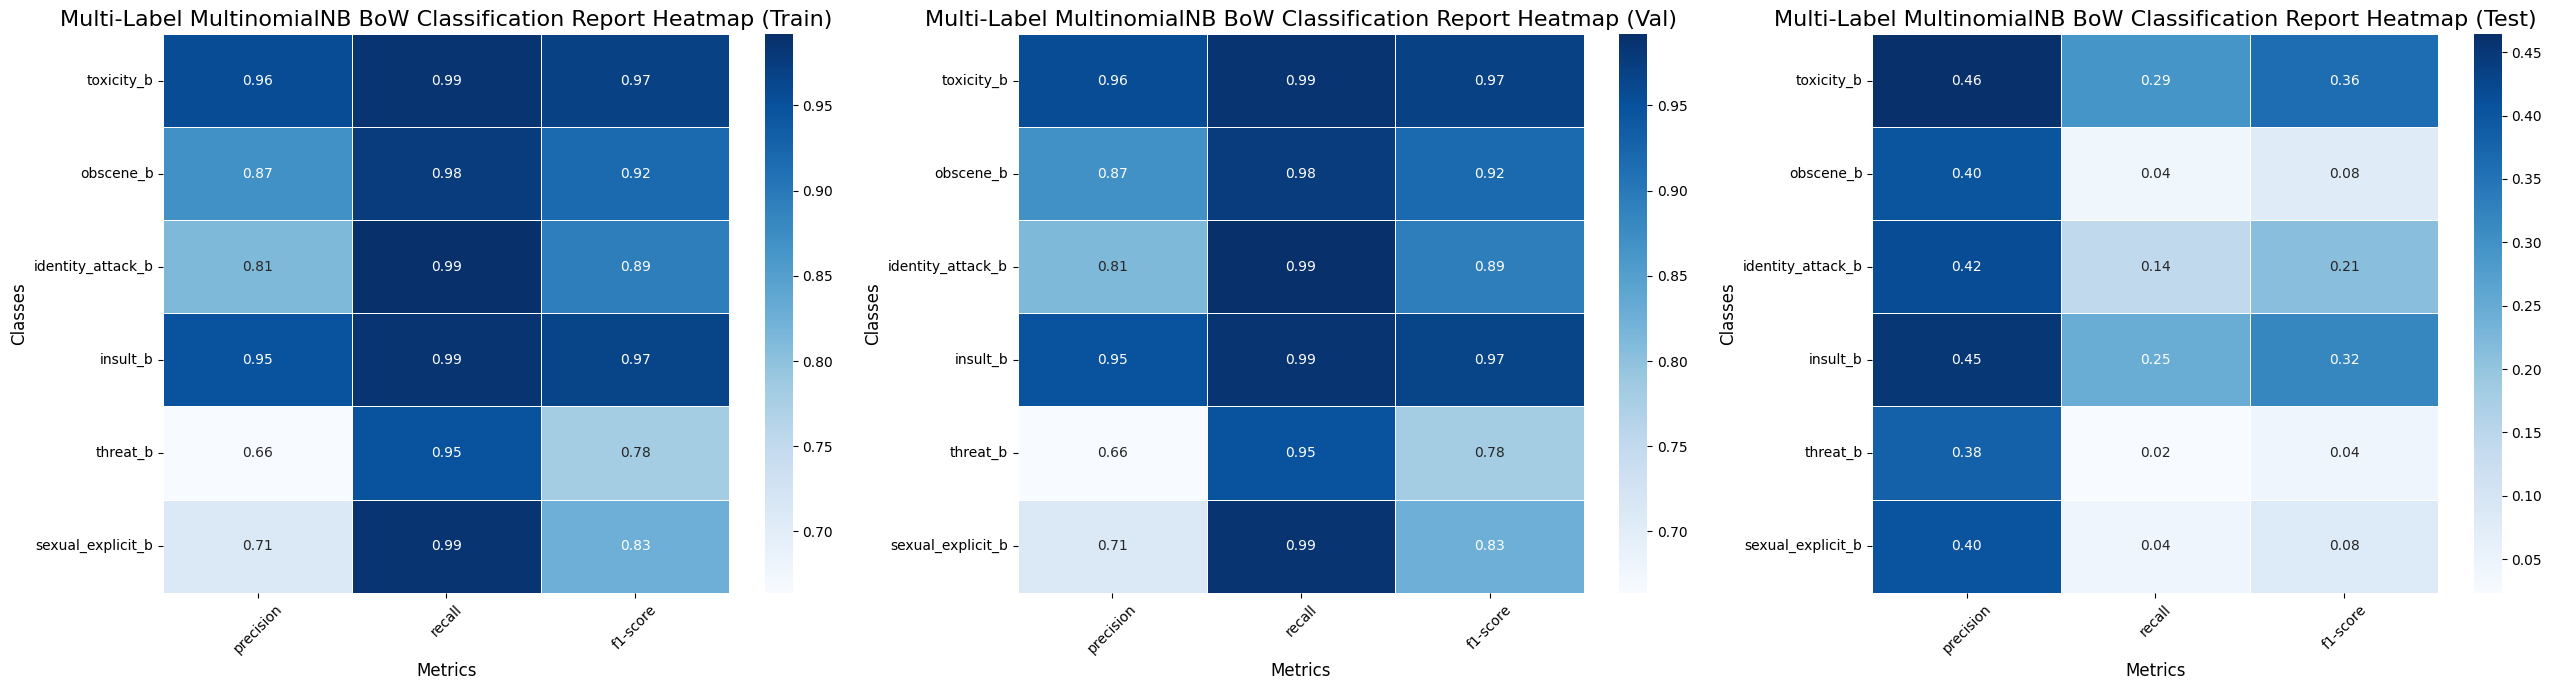

In [98]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_nb_bow_ngrams_pred_train,
    y_nb_bow_ngrams_pred_val,
    y_nb_bow_ngrams_pred_test,
    y_train.columns,
    'Multi-Label MultinomialNB BoW'
)

### Обучение с TF-IDF

#### Логистическая регрессия

In [102]:
y_log_reg_tfidf_pred_train, y_log_reg_tfidf_pred_val, y_log_reg_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=LogisticRegression(max_iter=1000),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

Multi-Label LogisticRegression TF-IDF

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.79,0.48,0.60,124469.00
obscene_b,0.70,0.29,0.41,8816.00
identity_attack_b,0.53,0.25,0.34,14574.00
insult_b,0.81,0.49,0.61,93907.00
threat_b,0.47,0.09,0.15,4892.00
sexual_explicit_b,0.46,0.13,0.21,4864.00
,precision,recall,f1-score,support
toxicity_b,0.78,0.48,0.59,33287.00
obscene_b,0.69,0.29,0.40,2062.00
identity_attack_b,0.53,0.26,0.35,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.78,0.45,0.57
macro avg,0.63,0.29,0.39
weighted avg,0.77,0.45,0.57
samples avg,0.05,0.05,0.05
,precision,recall,f1-score
micro avg,0.77,0.45,0.56
macro avg,0.61,0.29,0.38
weighted avg,0.76,0.45,0.56
samples avg,0.06,0.05,0.05
,precision,recall,f1-score


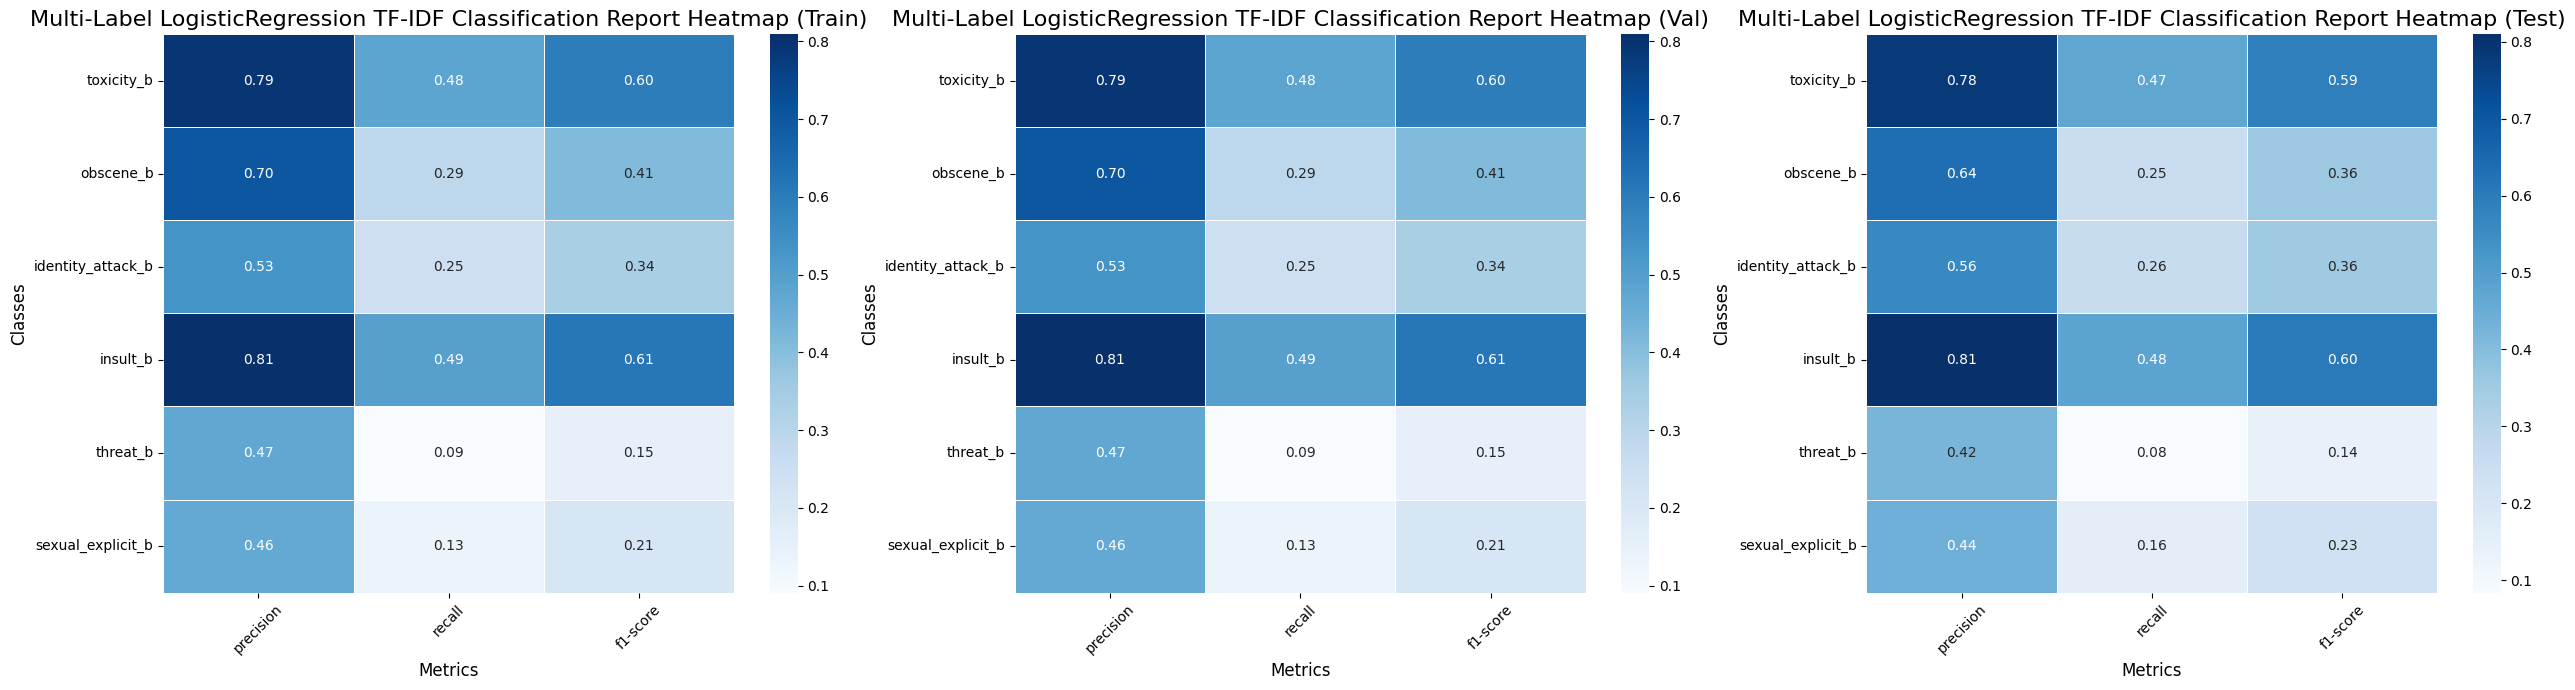

In [103]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_train.columns,
    'Multi-Label LogisticRegression TF-IDF'
)

#### SVM

In [ ]:
best_C = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, multi_label_svc_objective, n_trials=20).get('C', 1)

y_svm_tfidf_pred_train, y_svm_tfidf_pred_val, y_svm_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=LinearSVC(C=best_C, dual=False),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

In [ ]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_svm_tfidf_pred_train,
    y_svm_tfidf_pred_val,
    y_svm_tfidf_pred_test,
    y_train.columns,
    'Multi-Label SVM TF-IDF'
)

#### Наивный Байес

##### Слова

In [104]:
best_alpha = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, multi_label_mnb_objective).get('alpha', 1)

y_nb_tfidf_pred_train, y_nb_tfidf_pred_val, y_nb_tfidf_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2024-12-04 00:32:57,332] A new study created in memory with name: no-name-21608f94-6282-4fac-a3e2-44bc1c4aebc3
[I 2024-12-04 00:32:58,267] Trial 0 finished with value: 0.19318181818181818 and parameters: {'alpha': 0.06686561440598954}. Best is trial 0 with value: 0.19318181818181818.
[I 2024-12-04 00:32:59,191] Trial 1 finished with value: 0.19006107497250962 and parameters: {'alpha': 0.08153959086668196}. Best is trial 0 with value: 0.19318181818181818.
[I 2024-12-04 00:33:00,142] Trial 2 finished with value: 0.1911998305623213 and parameters: {'alpha': 0.07579155694626694}. Best is trial 0 with value: 0.19318181818181818.
[I 2024-12-04 00:33:01,102] Trial 3 finished with value: 0.16400708021997323 and parameters: {'alpha': 0.21611760648189324}. Best is trial 0 with value: 0.19318181818181818.
[I 2024-12-04 00:33:02,064] Trial 4 finished with value: 0.19642457217384432 and parameters: {'alpha': 0.05156780620419321}. Best is trial 4 with value: 0.19642457217384432.
[I 2024-12-04 00:

Multi-Label MultinomialNB TF-IDF

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.94,0.21,0.35,124469.00
obscene_b,0.96,0.11,0.20,8816.00
identity_attack_b,0.71,0.15,0.25,14574.00
insult_b,0.96,0.19,0.31,93907.00
threat_b,0.88,0.06,0.11,4892.00
sexual_explicit_b,0.89,0.14,0.25,4864.00
,precision,recall,f1-score,support
toxicity_b,0.82,0.14,0.24,33287.00
obscene_b,0.77,0.03,0.05,2062.00
identity_attack_b,0.53,0.04,0.08,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.93,0.19,0.32
macro avg,0.89,0.14,0.24
weighted avg,0.93,0.19,0.32
samples avg,0.02,0.02,0.02
,precision,recall,f1-score
micro avg,0.82,0.12,0.20
macro avg,0.63,0.06,0.10
weighted avg,0.80,0.12,0.20
samples avg,0.02,0.01,0.01
,precision,recall,f1-score


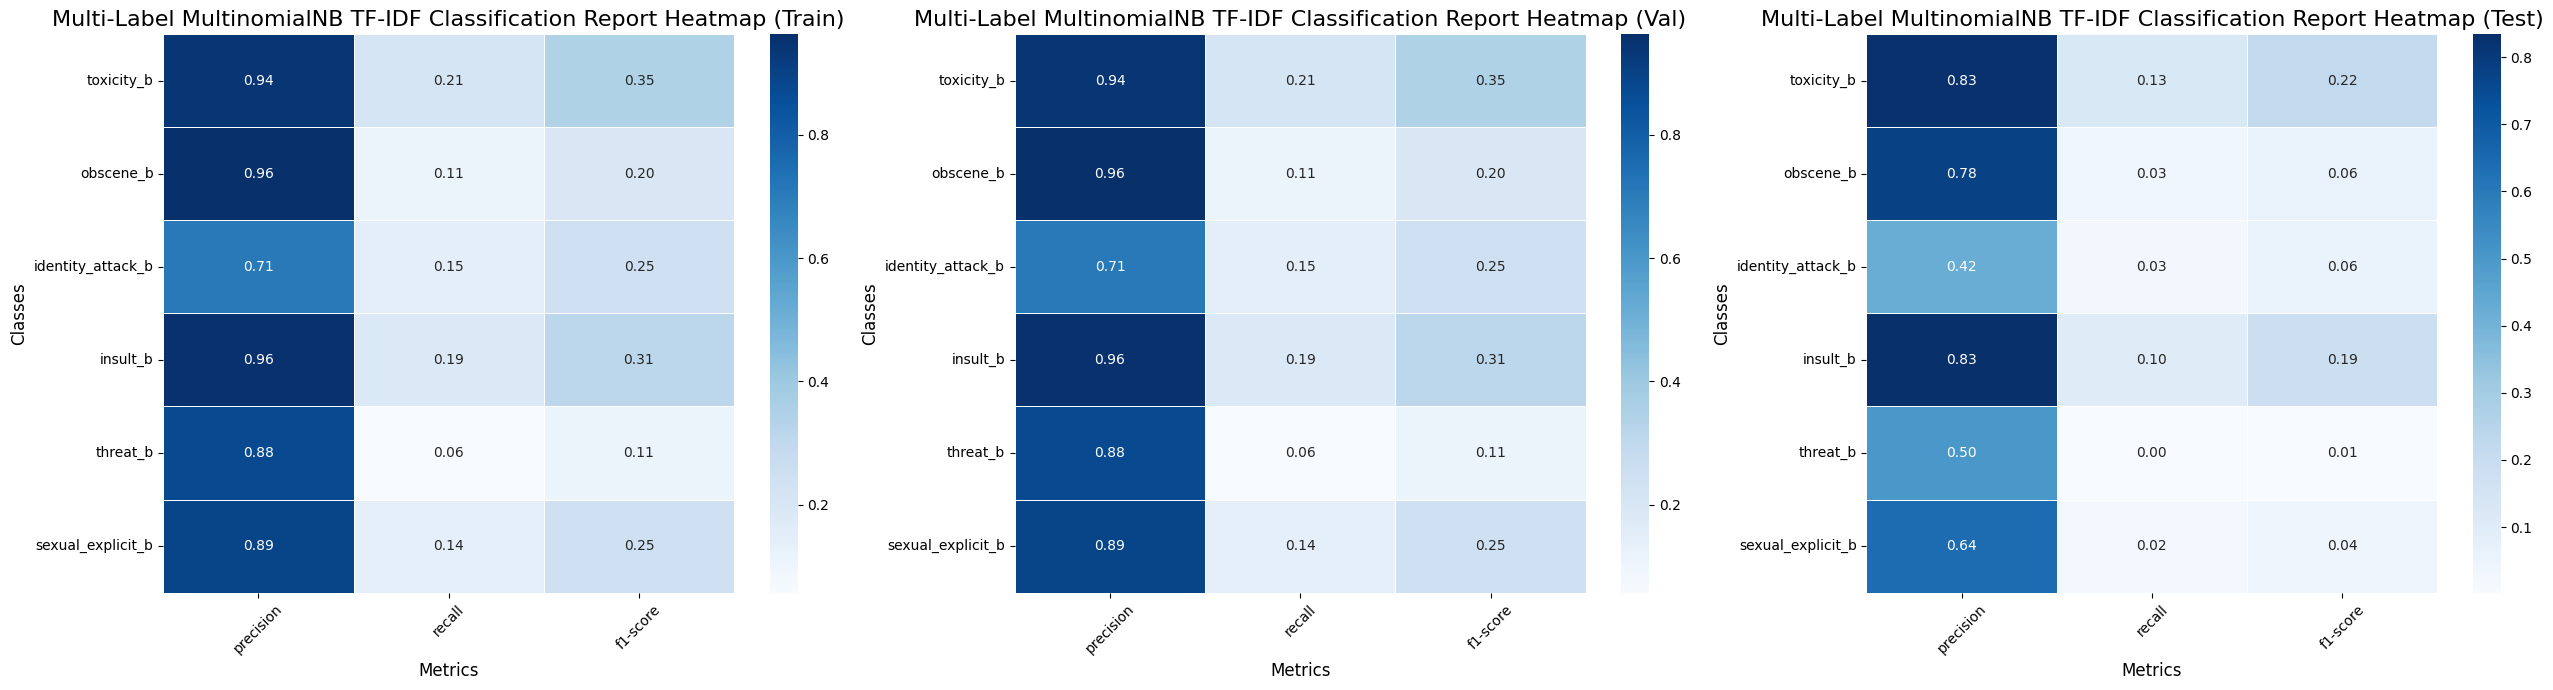

In [105]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_nb_tfidf_pred_test,
    y_train.columns,
    'Multi-Label MultinomialNB TF-IDF'
)

##### Биграммы, триграммы

In [106]:
best_alpha = get_hyperparams(X_train_tfidf_ngrams, X_val_tfidf_ngrams, y_train, y_val, multi_label_mnb_objective).get('alpha', 1)

y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_test = train_and_predict_toxicity_multilabel(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf_ngrams,
    X_val=X_val_tfidf_ngrams,
    X_test=X_test_tfidf_ngrams,
    y_train=y_train,
)

[I 2024-12-04 00:34:30,756] A new study created in memory with name: no-name-66c31923-ade3-4be5-8e1a-a4e4e8536631
[I 2024-12-04 00:34:56,735] Trial 0 finished with value: 0.1879133409350057 and parameters: {'alpha': 0.01952133837508049}. Best is trial 0 with value: 0.1879133409350057.
[I 2024-12-04 00:35:15,826] Trial 1 finished with value: 0.01036591686534674 and parameters: {'alpha': 0.4365235655565428}. Best is trial 0 with value: 0.1879133409350057.
[I 2024-12-04 00:35:35,281] Trial 2 finished with value: 0.059725075051350926 and parameters: {'alpha': 0.09840497996792101}. Best is trial 0 with value: 0.1879133409350057.
[I 2024-12-04 00:35:57,395] Trial 3 finished with value: 0.008803912850155625 and parameters: {'alpha': 0.5124824291025271}. Best is trial 0 with value: 0.1879133409350057.
[I 2024-12-04 00:36:17,011] Trial 4 finished with value: 0.06975417783608054 and parameters: {'alpha': 0.0833472664839999}. Best is trial 0 with value: 0.1879133409350057.
[I 2024-12-04 00:36:36,

Multi-Label MultinomialNB TF-IDF

METRICS PER CLASS



,precision,recall,f1-score,support
toxicity_b,0.98,0.99,0.99,124469.00
obscene_b,0.95,0.98,0.96,8816.00
identity_attack_b,0.94,0.99,0.96,14574.00
insult_b,0.98,0.99,0.99,93907.00
threat_b,0.92,0.94,0.93,4892.00
sexual_explicit_b,0.92,0.98,0.95,4864.00
,precision,recall,f1-score,support
toxicity_b,0.57,0.17,0.26,33287.00
obscene_b,0.57,0.02,0.04,2062.00
identity_attack_b,0.49,0.04,0.08,4593.00



OVERALL METRICS



,precision,recall,f1-score
micro avg,0.98,0.99,0.98
macro avg,0.95,0.98,0.96
weighted avg,0.98,0.99,0.98
samples avg,0.11,0.11,0.11
,precision,recall,f1-score
micro avg,0.57,0.14,0.22
macro avg,0.54,0.06,0.11
weighted avg,0.57,0.14,0.22
samples avg,0.02,0.02,0.02
,precision,recall,f1-score


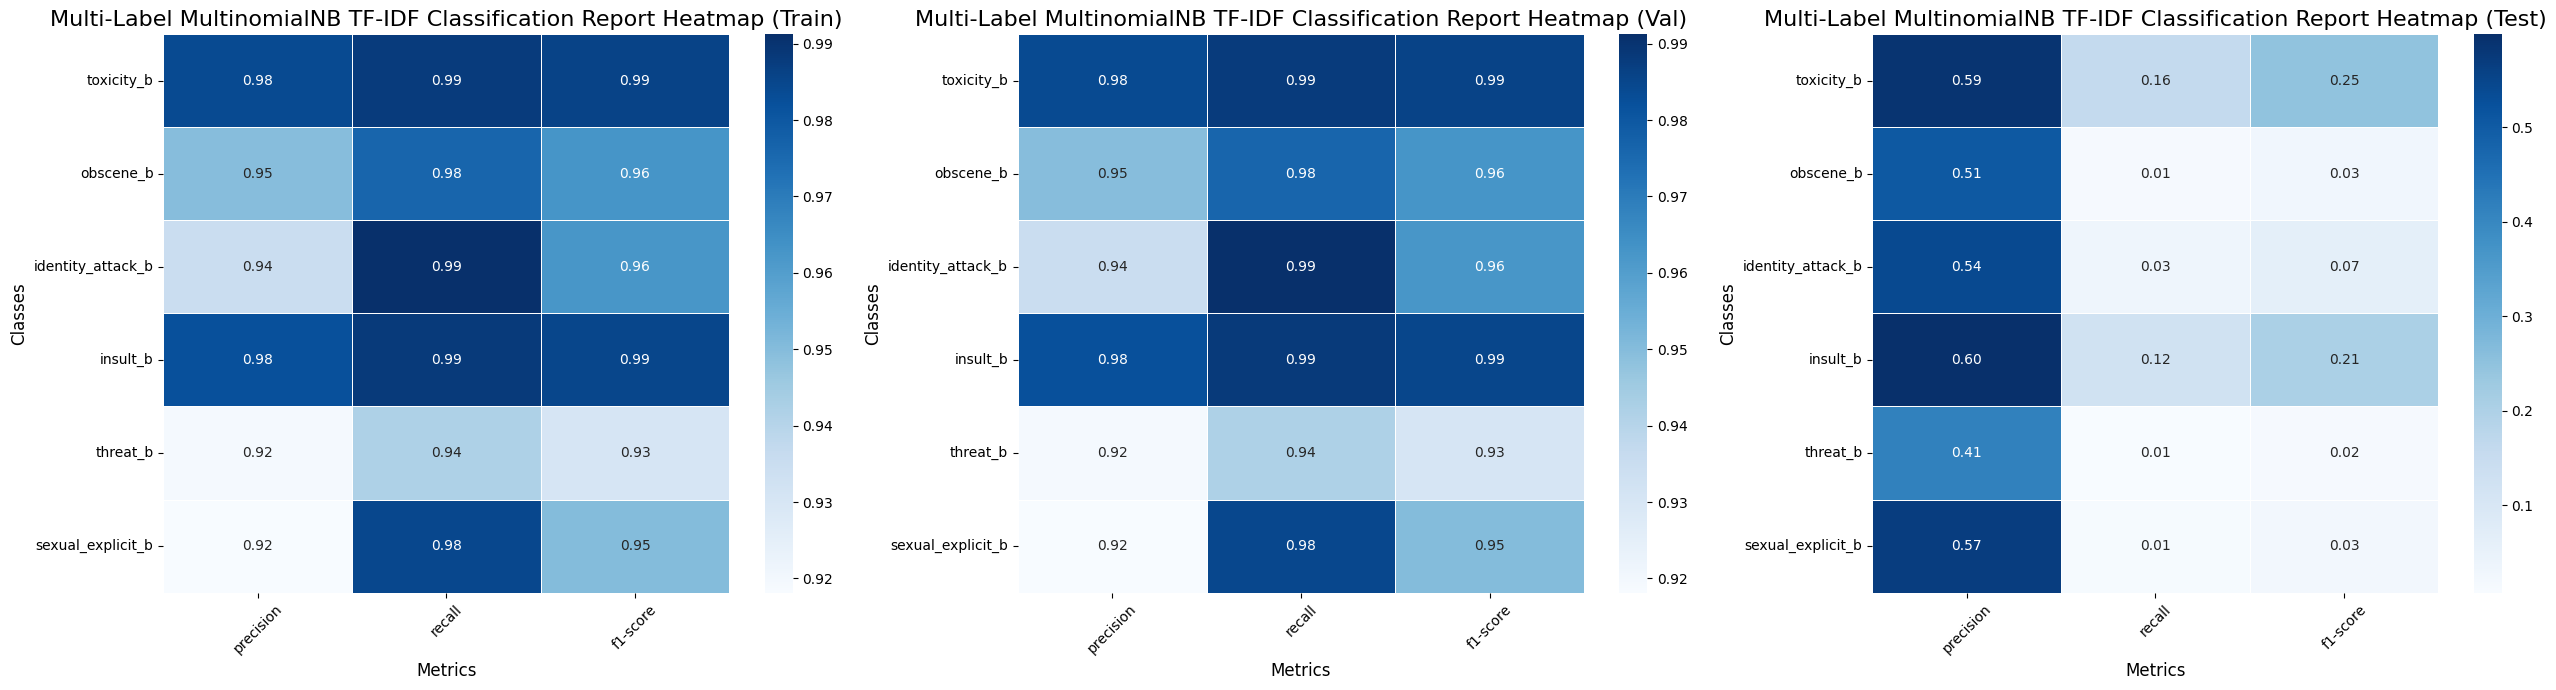

In [107]:
show_classification_report(
    y_train,
    y_val,
    y_test,
    y_nb_tfidf_ngrams_pred_train,
    y_nb_tfidf_ngrams_pred_val,
    y_nb_tfidf_ngrams_pred_test,
    y_train.columns,
    'Multi-Label MultinomialNB TF-IDF'
)